DO NOT CHANGE -- WORKING

500*batch_size

 {'params': self.model.logvariance, 'lr': 3e-3},
{'params': self.model.net_list[0].parameters(), 'lr': 5e-3},

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from tqdm import tqdm
import torch
import numpy as np
import pytorch_lightning as pl
from collections import defaultdict
import scipy

from gw150814_simulator import GW150814, defaults, GW150814_Additive
import os, sys
sys.path.append("../")
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule
from utils.gof import t_to_pvalue_empirical, t_to_pvalue

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('mystyle.mplstyle')

## Simulators

In [8]:
correlation_scales = torch.tensor([5]).int()
gw150814_post = torch.load('./stores/gw150814_white_post_d8_m1_1010k.pt')
gw150814_noise = torch.load('./stores/gw150814_white_noise_d8_m1_10M.pt')
gw150814_samples = {'mu': gw150814_post, 'noise': gw150814_noise}
simulator = GW150814_Additive(
    gw150814_samples=gw150814_samples, 
    bounds=torch.tensor([50]), #1.2341, 0.5696, 0.3403]), 
    dtype=torch.float32,
    correlation_scales = correlation_scales
)

times = simulator._process(simulator.times)
Nbins = simulator.Nbins

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from GW150814_posterior_samples.npz


#### Checks

100%|██████████| 500/500 [00:00<00:00, 749.22it/s] 


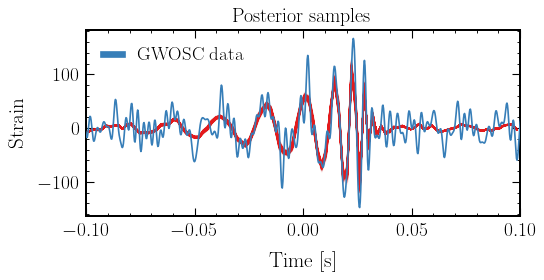

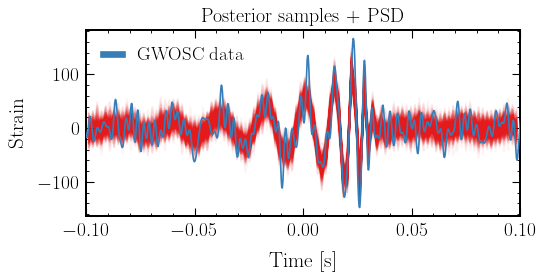

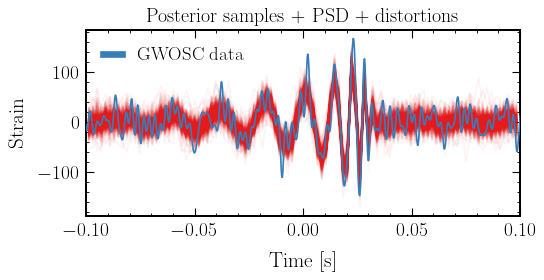

In [9]:
samples = simulator.sample(500)

# mu samples
plt.figure(figsize=(7, 3))
plt.title("Posterior samples")
for i in tqdm(range(500)):
    plt.plot(times, samples['mu'][i], color="C0", alpha=0.05)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color="C1", zorder=10, label="GWOSC data")
plt.xlim(-0.1, 0.1)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend();

# x0 samples
plt.figure(figsize=(7, 3))
plt.title("Posterior samples + PSD")
for i in tqdm(range(500)):
    plt.plot(times, samples['x0'][i], color="C0", alpha=0.05)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color="C1", zorder=10, label="GWOSC data")
plt.xlim(-0.1, 0.1)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend();

# xi samples
plt.figure(figsize=(7, 3))
plt.title("Posterior samples + PSD + distortions")
for i in tqdm(range(500)):
    plt.plot(times, samples['xi'][i, 0], color="C0", alpha=0.05)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color="C1", zorder=10, label="GWOSC data")
plt.xlim(-0.1, 0.1)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend();

## Training

In [10]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 
from models.resnet_1d import ResidualNet


class Network1D(torch.nn.Module):
    def __init__(self, correlation_scales):
        super().__init__()
        
        self.correlation_scales = correlation_scales
        self.online_norm = OnlineStandardizingLayer((len(correlation_scales), Nbins,), use_average_std=True) 
        self.logvariance = torch.nn.Parameter(torch.ones(len(correlation_scales), Nbins)*-2)  # Initialize to big value
               
        self.kernel_sizes = correlation_scales + (correlation_scales % 2 == 0).int()  
        self.paddings = (self.kernel_sizes  - 1)// 2 
        self.net = torch.nn.ModuleList(
                [ResidualNet(
                in_features=1, out_features=1, 
                hidden_features=128, num_blocks=2,
                dropout_probability=0.2,    
                kernel_size=self.kernel_sizes[i].item(), padding=self.paddings[i].item()
                ) for i in range(len(correlation_scales))]
        )
         
    def epsilon(self, x):
        x = self.online_norm(x)
        x = [self.net[i](x[:, i, :].unsqueeze(1)).squeeze(1) for i in range(len(self.correlation_scales))
        ]
        x = torch.stack(x, 1) 
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        cut = 5
        return self.logvariance.detach().exp().sqrt()[:, cut:-cut].mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        # ni = x['ni']
        # epsilon_sim =  (2 * self.bounds().unsqueeze(0).unsqueeze(2) * torch.rand(x['xi'].shape, device= x['xi'].device, dtype= x['xi'].dtype) - self.bounds().unsqueeze(0).unsqueeze(2)) * ni.unsqueeze(1)
        # cni_sim = torch.stack([simulator._conv1d(ni*epsilon_sim[:, i_c], int(c)) for i_c, c in enumerate(self.correlation_scales)], axis=1)
        # data =  x['x0'].unsqueeze(1) + cni_sim
        
        data = x['x']
        epsilon_sim = x['epsilon']
        
        epsilon = self.epsilon(data) #[B, #correlation_scales, N_bins]        
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                                    # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance               # [B, N_bins]
        
        return (l * mask.unsqueeze(1).float()).sum() * 0.5
    
network = Network1D(correlation_scales)
network.bounds()
network.cuda().eval();

/tmp/ipykernel_1105485/4182250455.py:15: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.paddings = (self.kernel_sizes  - 1)// 2


In [11]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    sample = {k: v for k, v in sample.items()}
    return sample

batch_size = 128
# samples = simulator.sample(Nsims=100_000, show_progress=True)
# dm = StoredDataModule(samples, batch_size=batch_size) #, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=500*batch_size, batch_size=batch_size)
network = Network1D(correlation_scales)
model = CustomLossModule_withBounds(network)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=100, 
    precision=32,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network.cuda().eval();

/tmp/ipykernel_1105485/4182250455.py:15: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.paddings = (self.kernel_sizes  - 1)// 2
/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/noemiam/.pyenv/versions/swyft-3.10.0/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | Network1D | 328 K 
------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.315     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1678.488


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 743.373 >= min_delta = 0.0. New best score: 935.116


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 403.976 >= min_delta = 0.0. New best score: 531.140


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.297 >= min_delta = 0.0. New best score: 521.842


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 259.232 >= min_delta = 0.0. New best score: 262.610


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 1.5000e-03.
Epoch 00013: reducing learning rate of group 1 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 262.610. Signaling Trainer to stop.


Reloading best model: /home/noemiam/sbi/gofish/GW/lightning_logs/version_45/checkpoints/epoch=6-val_loss=262.61.ckpt


In [12]:
# checkpoint = torch.load("./lightning_logs/version_103/checkpoints/epoch=95-val_loss=-457.24.ckpt")
# state_dict = checkpoint['state_dict']
# new_state_dict = {}
# for key in state_dict:
#     new_key = key.replace('model.', '')  # Remove 'model.' prefix
#     new_state_dict[new_key] = state_dict[key]
    
# network.load_state_dict(new_state_dict)
# network.cuda().eval();# 

In [13]:
# # Convert tensors to scalars if they are tensors
# train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
# bounds_history = torch.stack([torch.tensor(bound.item()) if bound.numel() == 1 else torch.tensor(bound) for bound in model.bounds_history]).cpu()
# torch.save(train_loss_history, f"{trainer.checkpoint_callback.best_model_path}+loss.pt")
# torch.save(bounds_history, f"{trainer.checkpoint_callback.best_model_path}+bounds.pt")
# print(f"{trainer.checkpoint_callback.best_model_path}+loss.pt")

# # Generate a list of epoch numbers
# epochs = range(1, len(train_loss_history) + 1)

# fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# # Plot Training Loss over Epochs
# axs[0].plot(epochs, train_loss_history, c='k')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Training Loss')
# # Plot Bounds over Epochs
# labels = ["A", "B", "C"]
# for i in range(len(correlation_scales)):
#     axs[1].plot(epochs, bounds_history[:, i], label=f'{labels[i]}')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Bounds')
# axs[1].legend()
# # axs[1].set_ylim(0,2)
# plt.tight_layout();

# network.bounds()

In [14]:
# # Distotions enveloping the data
# sample = simulator.sample(1)
# ni = sample['ni']
# c = ['C0', 'C1', 'C2']

# fig, axs = plt.subplots(20, 3, figsize=(12, 48), sharex=True)
# for i_b, b in enumerate(bounds_history):
#     if i_b < len(axs):
#         for i in range(len(b)):
#             axs[i_b,i].set_title(r"$b$ = {:.2f}".format(b[i]))
#             for j in range(10):
#                 sample = simulator.sample(1)
#                 axs[i_b, i].plot(sample['mu'][0].cpu(), c='k', ls='--')
#                 ni = sample['ni']
#                 epsilon_sim =  (2 * b.unsqueeze(0).unsqueeze(2) * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b.unsqueeze(0).unsqueeze(2)) * ni.unsqueeze(1)
#                 cni_sim = torch.stack([simulator._conv1d(ni*epsilon_sim[:, i_c], int(c)) for i_c, c in enumerate(correlation_scales)], axis=1)
#                 data =  sample['x0'].unsqueeze(1) + cni_sim
#                 axs[i_b, i].plot(data[0,i].cpu(), c=c[i], alpha=0.4)
# plt.tight_layout();

In [15]:
# # Distotions enveloping the data
# sample = simulator.sample(1)
# ni = sample['ni']
# c = ['C0', 'C1', 'C2']

# fig, axs = plt.subplots(3, 6, figsize=(18, 6), sharex=True)
# for i in range(3):
#     for ii, idx_epoch in enumerate([0,2,4,6,8,-1]):
#         axs[0,ii].set_title(r"Epoch = {:.0f}".format(int(epochs[idx_epoch])))
#         b = bounds_history[idx_epoch]
#         axs[i, ii].set_xticklabels([])
#         axs[i, ii].plot([],[], label=r"$b$ = {:.2f}".format(b[i]))
#         axs[i, ii].legend(loc='upper left', fontsize=12, handlelength=0)
#         for j in range(10):
#             sample = simulator.sample(1)
#             axs[i, ii].plot(sample['mu'][0].cpu(), c='k', ls='--')
#             ni = sample['ni']
#             epsilon_sim =  (2 * b.unsqueeze(0).unsqueeze(2) * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b.unsqueeze(0).unsqueeze(2)) * ni.unsqueeze(1)
#             cni_sim = torch.stack([simulator._conv1d(ni*epsilon_sim[:, i_c], int(c)) for i_c, c in enumerate(correlation_scales)], axis=1)
#             data =  sample['x0'].unsqueeze(1) + cni_sim
#             axs[i, ii].plot(data[0,i].cpu(), c=c[i], alpha=0.4)
        
# plt.tight_layout()
# # plt.savefig('adaptive.pdf', transparent=True, dpi=300);

(0.0, 0.05)

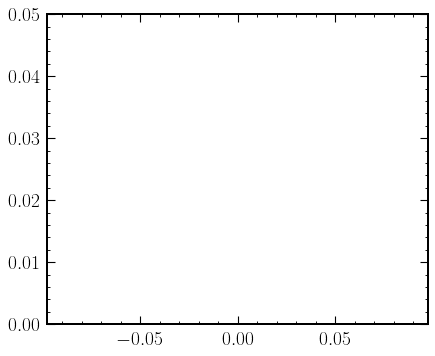

In [16]:
cut = 5

for i in range(len(correlation_scales)):
    plt.plot(times[cut:-cut], network.logvariance.exp().detach().cpu()[i][cut:-cut]);
plt.ylim(0,0.05)

---

## Evaluate

#### From here on test with bounds to which the NN converged: 

In [17]:
# # bounds = network.bounds().detach().cpu()
# bounds=torch.tensor([0.9, 0.4, 0.21])
# simulator = GW150814_Additive(
#     settings=defaults,
#     gw150814_samples=gw150814_samples, 
#     bounds=bounds, 
#     correlation_scales = correlation_scales,
#     dtype=torch.float32, 
# )

# bounds

#### Monte-Carlo H0

$$
    t_i(\mathbf x) \propto \text{SNR}_i^2(\bm x)  
$$

In [18]:
N_mc = 1e5

# if os.path.exists("mc_h0.npy"):
#     ts_bin_H0 = np.load("mc_h0.npy")
# else:
batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0 = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_batch = (network.snr(mc_samples['x0'].unsqueeze(1).expand(-1, len(simulator.correlation_scales), Nbins).cuda())**2).detach().cpu().numpy()
    ts_bin_H0.append(ts_batch)
    
ts_bin_H0 = np.concatenate(ts_bin_H0)
ts_bin_H0.shape

 62%|██████▎   | 15/24 [00:12<00:07,  1.13it/s]

100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


(98304, 1, 102)

Histogram of $t_i | H_0$ in individual bins

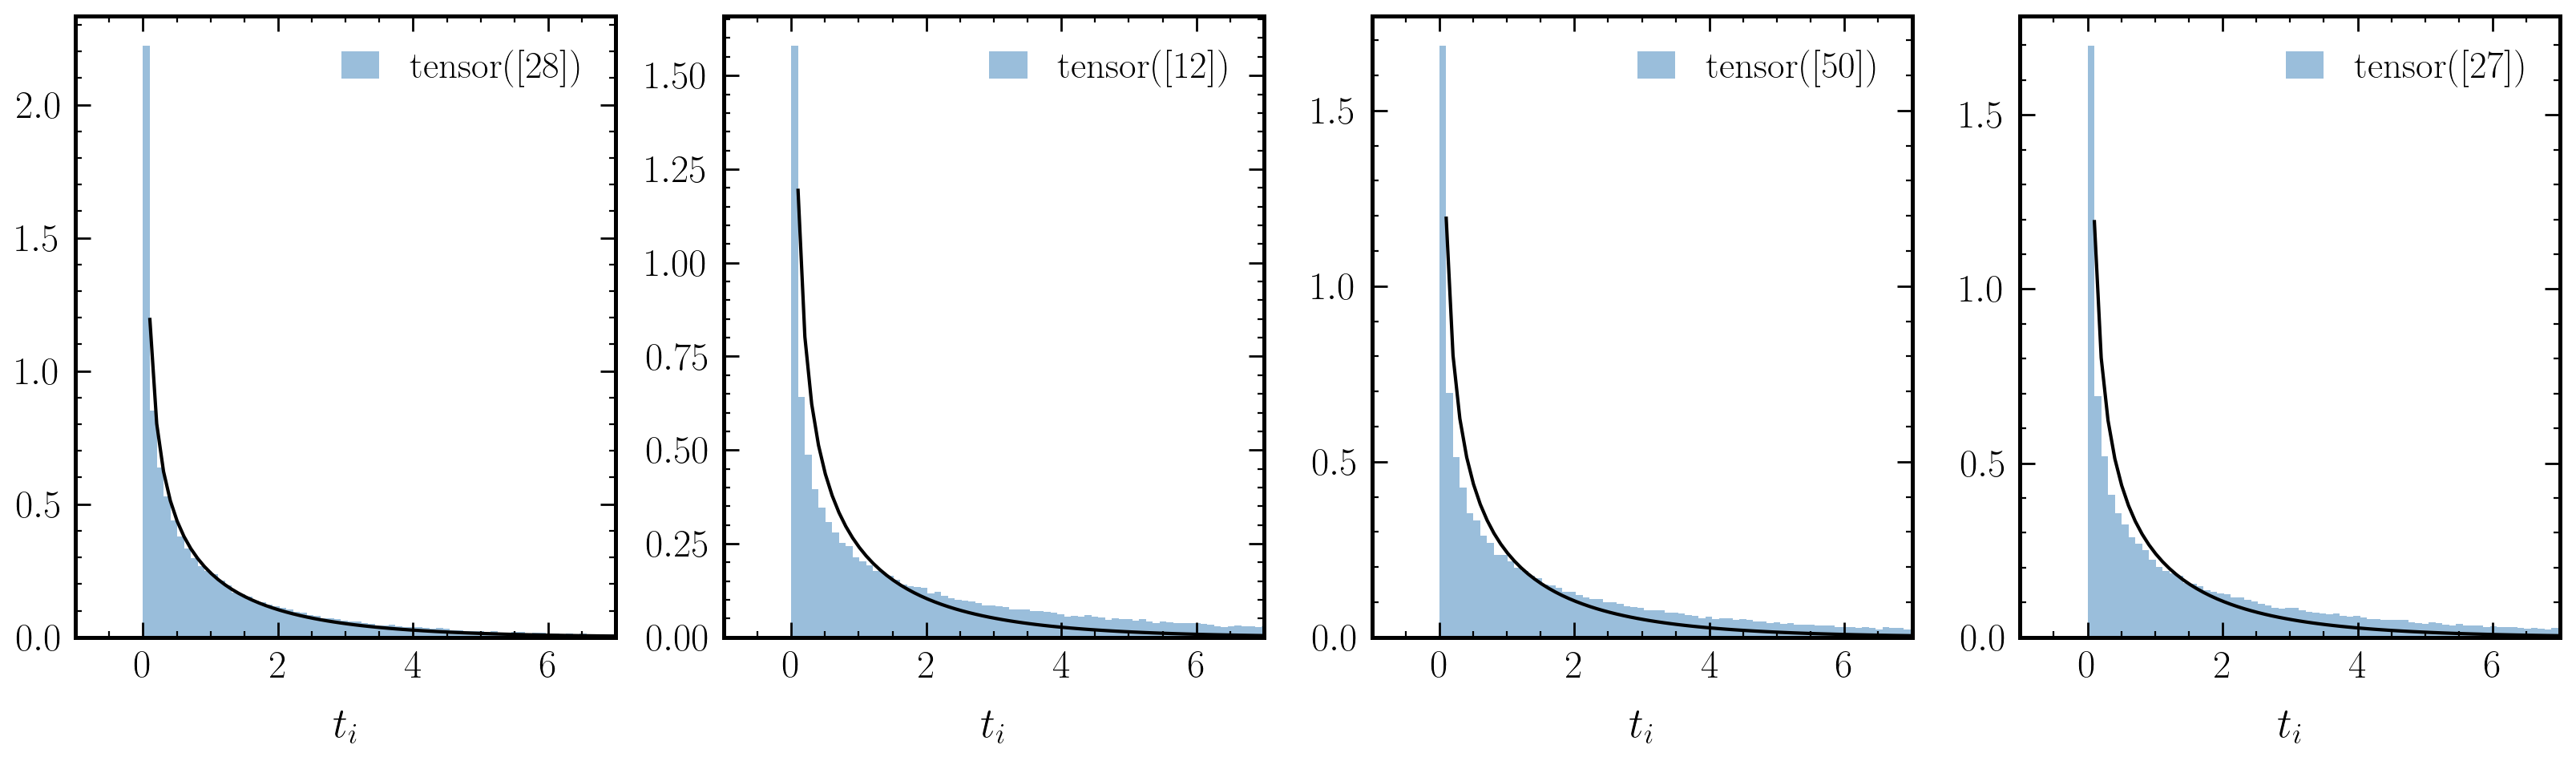

In [19]:
# Compare with chi2 with df = 1 ?
grid = np.linspace(0, 10, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=0)

for idx_c in range(len(correlation_scales)):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
    for i in range(4):
        bin = torch.randint(Nbins, (1,))
        ts_bin_i = ts_bin_H0[:, idx_c, bin]

        bins = np.linspace(0, 10, 100)
        axs[i].hist(ts_bin_i, bins=bins, density=True, color='C1', alpha=0.5, label=f'{bin}')
        
        axs[i].set_xlabel('$t_i$')
        axs[i].set_xlim(-1, 7)
        axs[i].plot(grid, chi2, c='k')
        axs[i].legend();
    plt.show()

---

### Individual deviations test

- Localized $t_i$
- Localized $\mathrm{p}_i$ for anomaly detection
- Residual analysis with $\epsilon_i$ map

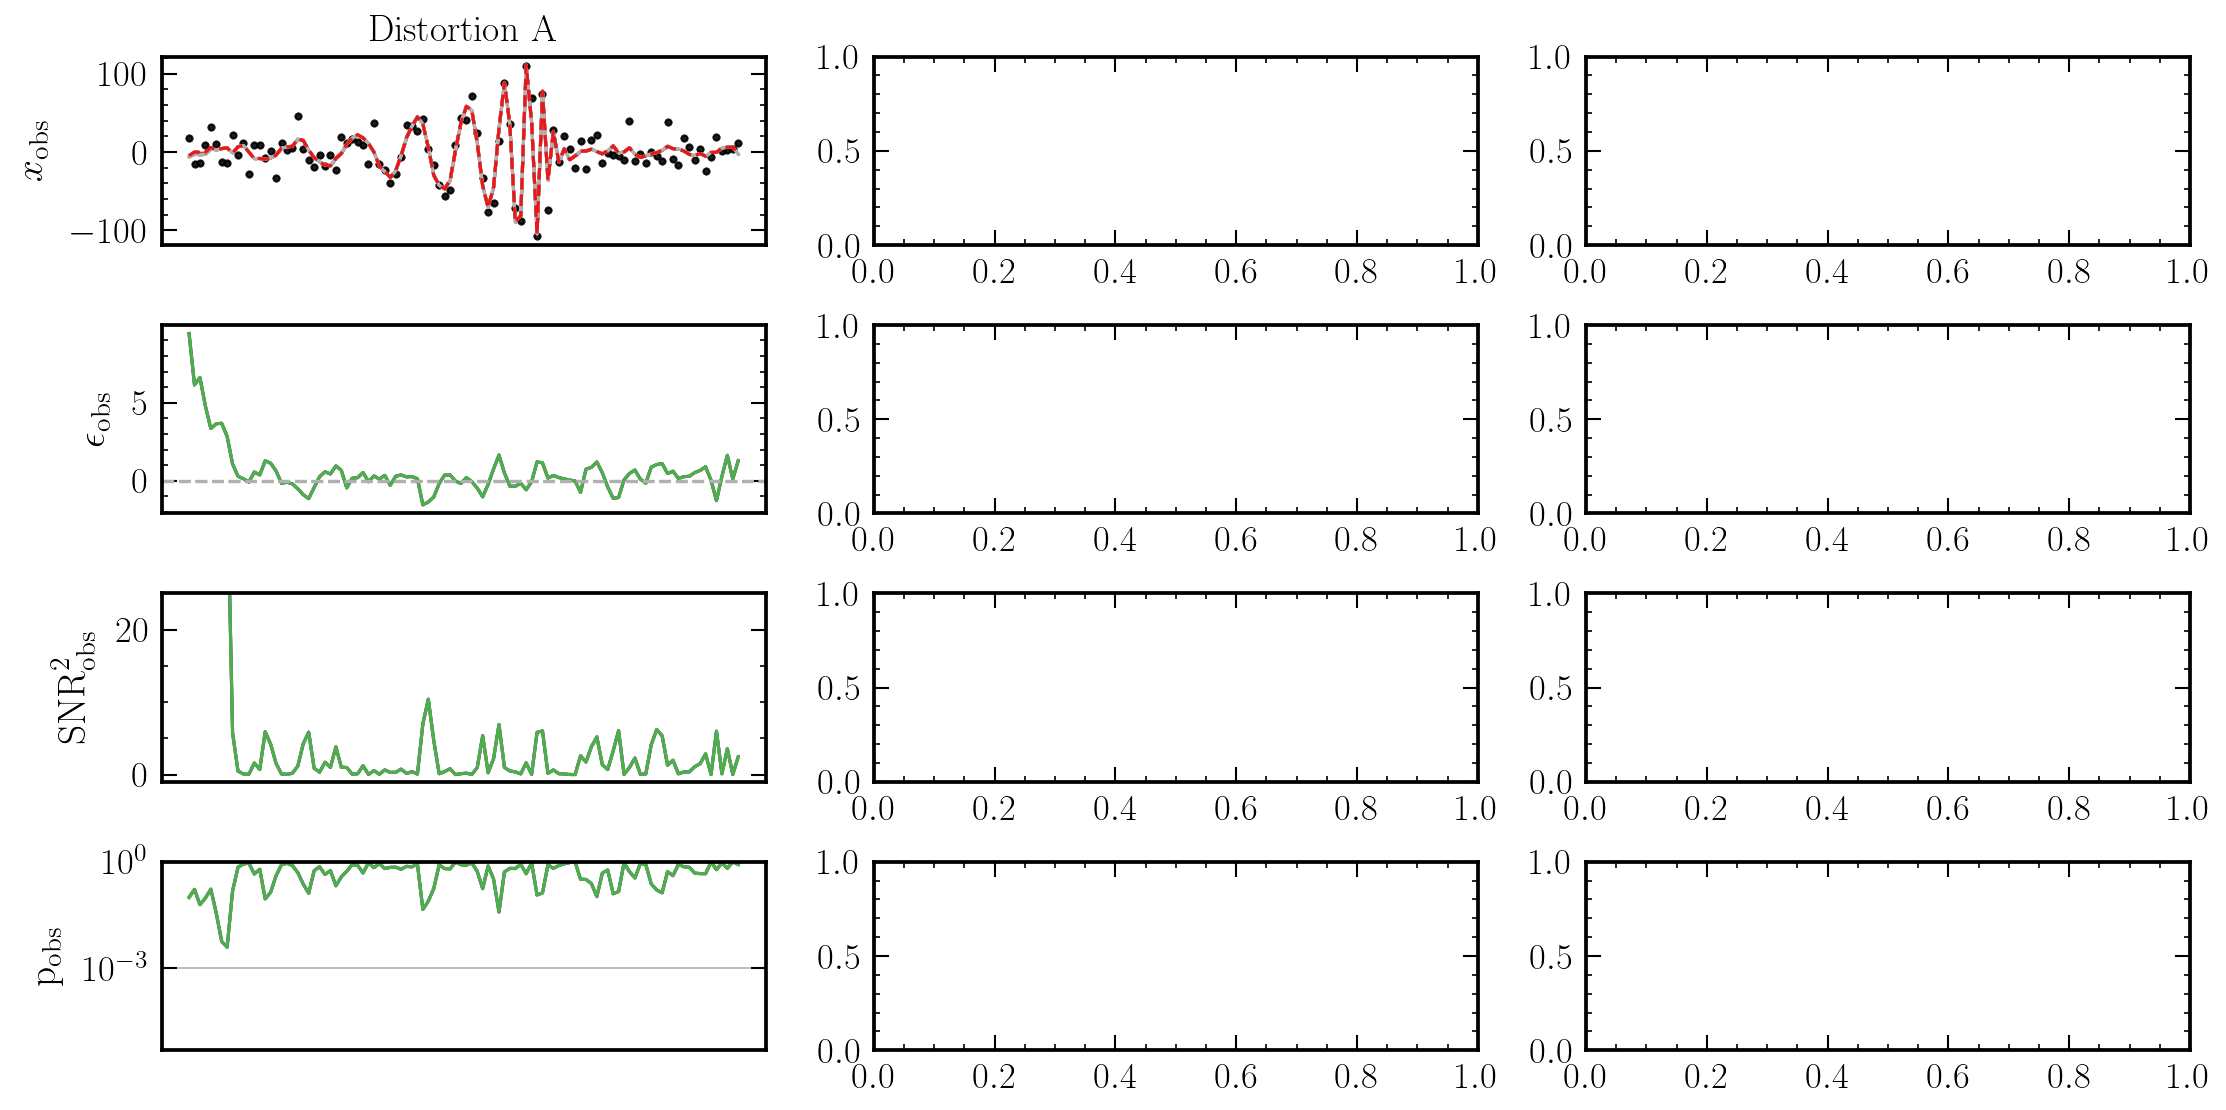

In [20]:
obs = simulator.sample(1) 
# torch.save(obs, "figures/test_gaussian_3.pt")
# obs = torch.load("figures/test_gaussian_3.pt")
dist = obs['xi'] - obs['x0'].unsqueeze(1)
grid = times 

fig, axs = plt.subplots(4, 3, figsize=(15, 7.5), dpi=150)
c = ['C0', 'C1', 'C2']
labels = ["A", "B", "C"]
for _ in range(3):
    
    i =0
    target = obs['xi'][:, i].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    snr2_nn = network.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]

    # Compute p-values
    _p_nn = []
    for idx, ts_bin in enumerate(snr2_nn.T):
        ts_bin_i = ts_bin_H0[:, :, idx]          #[N_mc, len(correlation_scales)]
        m = ts_bin_i.mean(0)                     #[len(correlation_scales)]
        ts0_ref = ts_bin_i - m                   #[N_mc, len(correlation_scales)]
        ts_obs = (ts_bin - m)
        _p_nn.append(np.stack([
            t_to_pvalue_empirical(ts_obs[c], ts0_ref[:, c]) for c in range(len(simulator.correlation_scales))
        ], axis=0))        #[len(correlation_scales)]
    p_nn = np.array(_p_nn)                   #[Nbins, len(correlation_scales)]
    
    # Plotting
    axs[0, i].plot(grid, obs['mu'][0], color='#b0b0b0', label="$\mu_{\mathrm{sim}}$")
    axs[0, i].scatter(grid, obs['xi'][0, i], color='k', alpha=0.5, s=8)
    # axs[0, i].errorbar(grid, obs['xi'][0, i], yerr=1, fmt='none', ecolor='k', alpha=0.5)
    axs[0, i].plot(grid, obs['mu'][0]+dist[0, i], color=c[i], ls='--', label="$\mu_{\mathrm{dist}}$")
    axs[0, i].fill_between(grid, obs['mu'][0], obs['mu'][0]+dist[0, i], color=c[i], alpha=0.5)
    axs[0, i].set_title(f"Distortion {labels[i]}")
    # axs[0, i].set_ylim(-2., 2.)
    axs[0, i].set_xticks([])
    
    axs[1, i].plot(grid, epsilon_nn.T)
    # axs[1, i].set_ylim(-2., 2.)
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    axs[1, i].set_xticks([])
    
    axs[2, i].plot(grid, snr2_nn.T)
    axs[2, i].set_ylim(-1, 25)
    axs[2, i].set_xticks([])

    axs[3, i].semilogy(grid, p_nn)
    axs[3, i].set_ylim(1/(N_mc*2), 1)
    axs[3, i].grid(True, axis='y')
    axs[3, i].set_xticks([])
    
# axs[0, 0].legend()
axs[0, 0].set_ylabel("$x_\mathrm{obs}$")
axs[1, 0].set_ylabel(r"$\epsilon_\mathrm{obs}$")
axs[2, 0].set_ylabel(r"$\mathrm{SNR}^2_\mathrm{obs}$")
axs[3, 0].set_ylabel("$\mathrm{p}_\mathrm{obs}$")
# axs[1, 0].legend(loc='best')
# axs[2, 0].legend(loc='best')
# axs[3, 0].legend(loc='best')
plt.tight_layout();

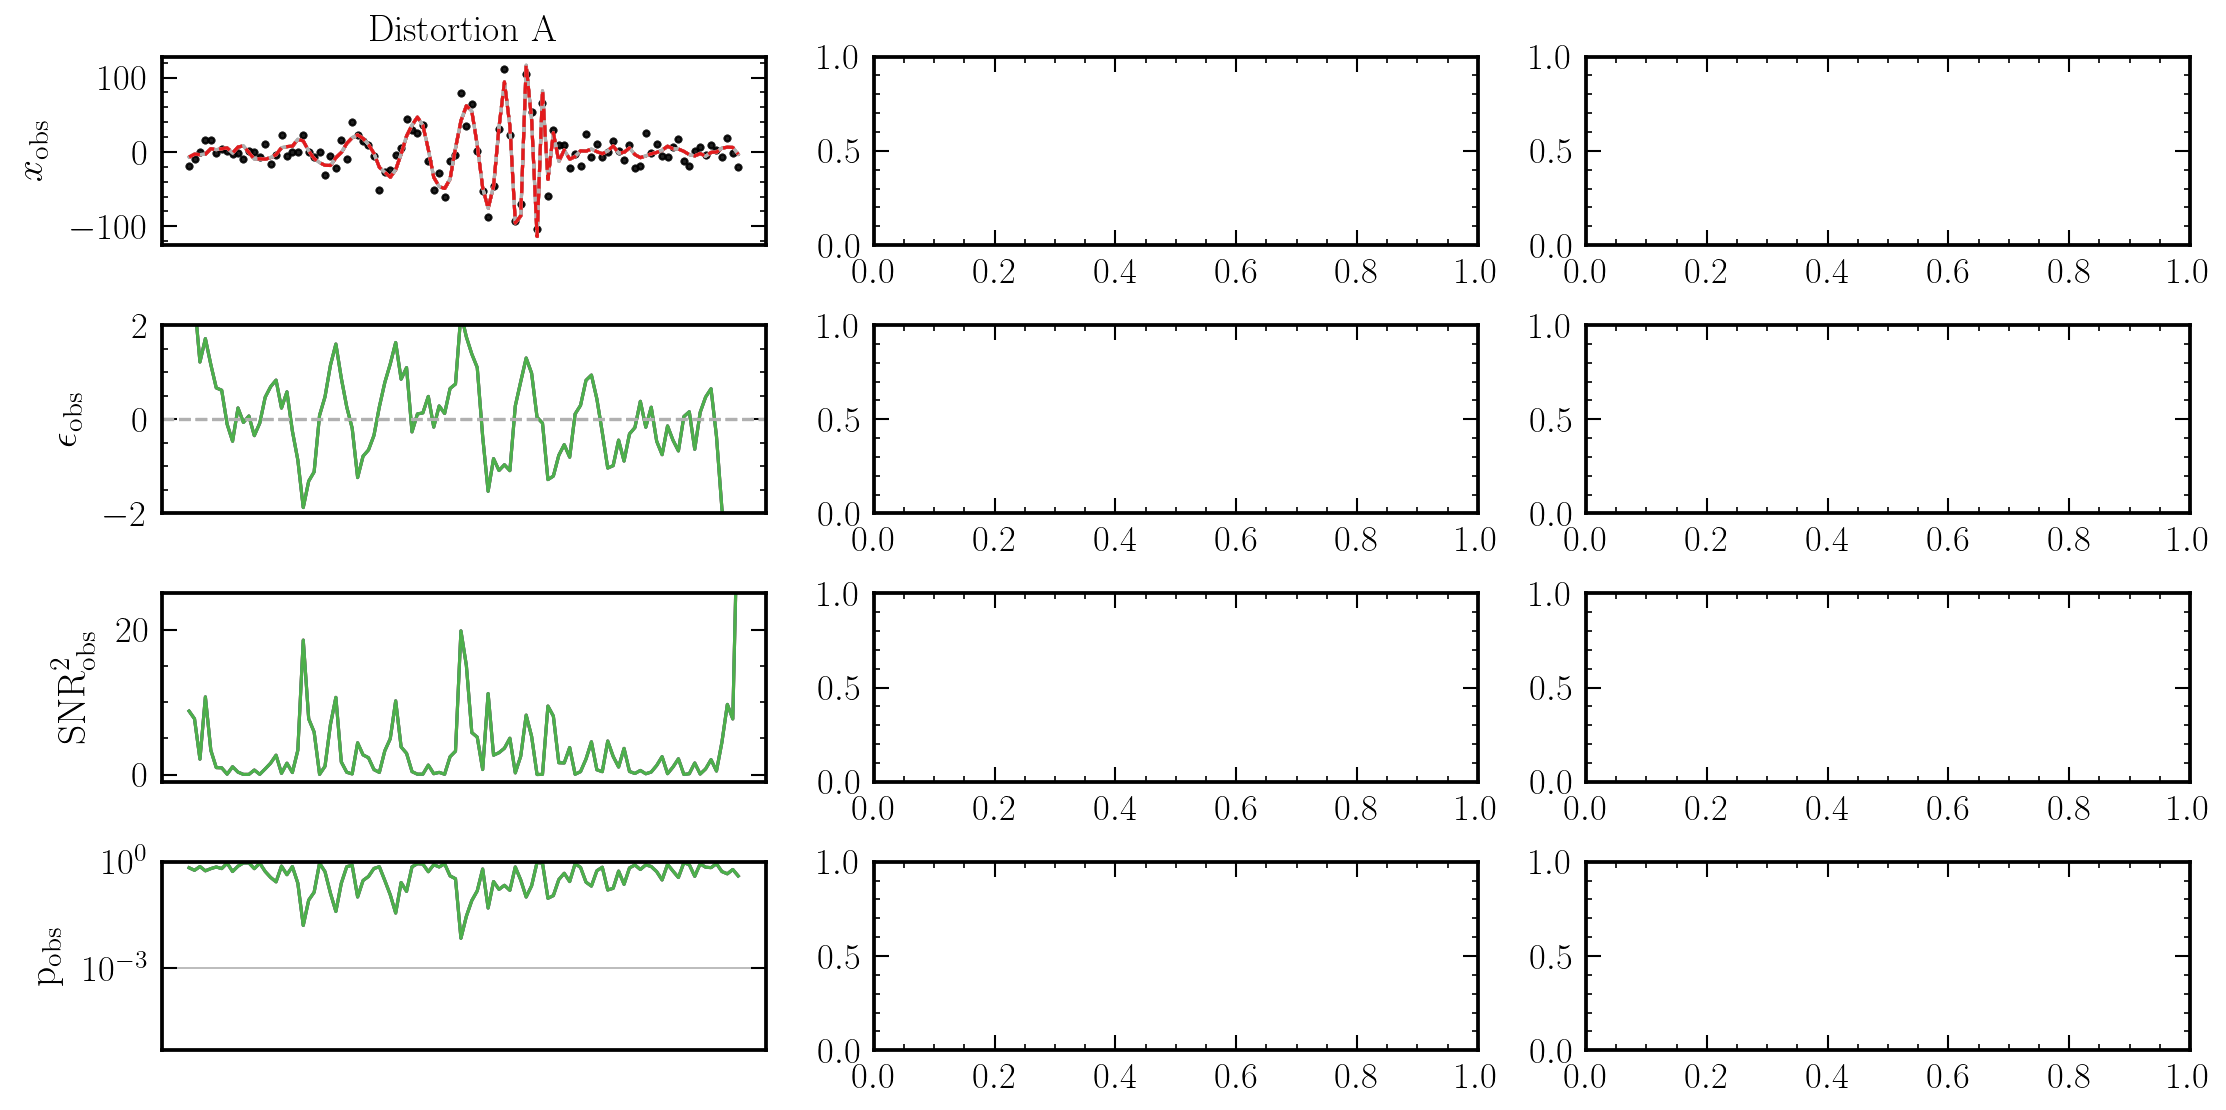

In [21]:
# NO SIGNAL
obs = simulator.sample(1) 
# torch.save(obs, "figures/test_gaussian_3.pt")
# obs = torch.load("figures/test_gaussian_3.pt")

obs['xi'] = obs['x0'].unsqueeze(1).repeat(1, len(simulator.correlation_scales), 1)
dist = obs['xi'] - obs['x0']
grid = times 

fig, axs = plt.subplots(4, 3, figsize=(15, 7.5), dpi=150)
c = ['C0', 'C1', 'C2']
labels = ["A", "B", "C"]
for _ in range(3):
    i=0
    target = obs['xi'][:, i].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    snr2_nn = network.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]

    # Compute p-values
    _p_nn = []
    for idx, ts_bin in enumerate(snr2_nn.T):
        ts_bin_i = ts_bin_H0[:, :, idx]          #[N_mc, len(correlation_scales)]
        m = ts_bin_i.mean(0)                     #[len(correlation_scales)]
        ts0_ref = ts_bin_i - m                   #[N_mc, len(correlation_scales)]
        ts_obs = (ts_bin - m)
        _p_nn.append(np.stack([
            t_to_pvalue_empirical(ts_obs[c], ts0_ref[:, c]) for c in range(len(simulator.correlation_scales))
        ], axis=0))        #[len(correlation_scales)]
    p_nn = np.array(_p_nn)                   #[Nbins, len(correlation_scales)]
    
    # Plotting
    axs[0, i].plot(grid, obs['mu'][0], color='#b0b0b0', label="$\mu_{\mathrm{sim}}$")
    axs[0, i].scatter(grid, obs['xi'][0, i], color='k', alpha=0.5, s=8)
    # axs[0, i].errorbar(grid, obs['xi'][0, i], yerr=1, fmt='none', ecolor='k', alpha=0.5)
    axs[0, i].plot(grid, obs['mu'][0]+dist[0, i], color=c[i], ls='--', label="$\mu_{\mathrm{dist}}$")
    axs[0, i].fill_between(grid, obs['mu'][0], obs['mu'][0]+dist[0, i], color=c[i], alpha=0.5)
    axs[0, i].set_title(f"Distortion {labels[i]}")
    # axs[0, i].set_ylim(-2., 2.)
    axs[0, i].set_xticks([])
    
    axs[1, i].plot(grid, epsilon_nn.T)
    axs[1, i].set_ylim(-2., 2.)
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    axs[1, i].set_xticks([])
    
    axs[2, i].plot(grid, snr2_nn.T)
    axs[2, i].set_ylim(-1, 25)
    axs[2, i].set_xticks([])

    axs[3, i].semilogy(grid, p_nn)
    axs[3, i].set_ylim(1/(N_mc*2), 1)
    axs[3, i].grid(True, axis='y')
    axs[3, i].set_xticks([])
    
# axs[0, 0].legend()
axs[0, 0].set_ylabel("$x_\mathrm{obs}$")
axs[1, 0].set_ylabel(r"$\epsilon_\mathrm{obs}$")
axs[2, 0].set_ylabel(r"$\mathrm{SNR}^2_\mathrm{obs}$")
axs[3, 0].set_ylabel("$\mathrm{p}_\mathrm{obs}$")
# axs[1, 0].legend(loc='best')
# axs[2, 0].legend(loc='best')
# axs[3, 0].legend(loc='best')
plt.tight_layout();

---

### Total deviations test

- Aggregated $t_{\rm sum}(x) = \sum_{i=1}^{N_{\rm alt}} - 2 \log\frac{p(x|H_0)}{p(x|H_i)} $
- Aggregated $\mathrm{p}_{\rm sum}$ for model validation
- Residual variance analysis with $\epsilon_i$ histogram

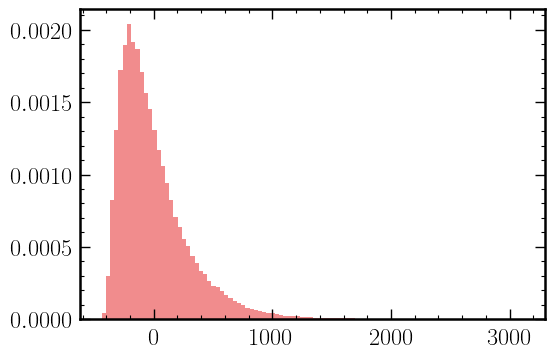

In [22]:
# From MCMC samples
ts_sum_H0 = ts_bin_H0.sum(axis=-1)                  #[N_mc, len(correlation_scales)]
ts_sum_H0_mean = ts_sum_H0.mean(0, keepdims=True)   #[1, len(correlation_scales)]
ts_sum_H0 = ts_sum_H0 - ts_sum_H0_mean              #[N_mc, len(correlation_scales)]   

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
bins = np.linspace(ts_sum_H0.min(), ts_sum_H0.max(), 100)
for i in range(len(correlation_scales)):
    ax.hist(ts_sum_H0[:, i], bins=100, alpha=0.5, density=True);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


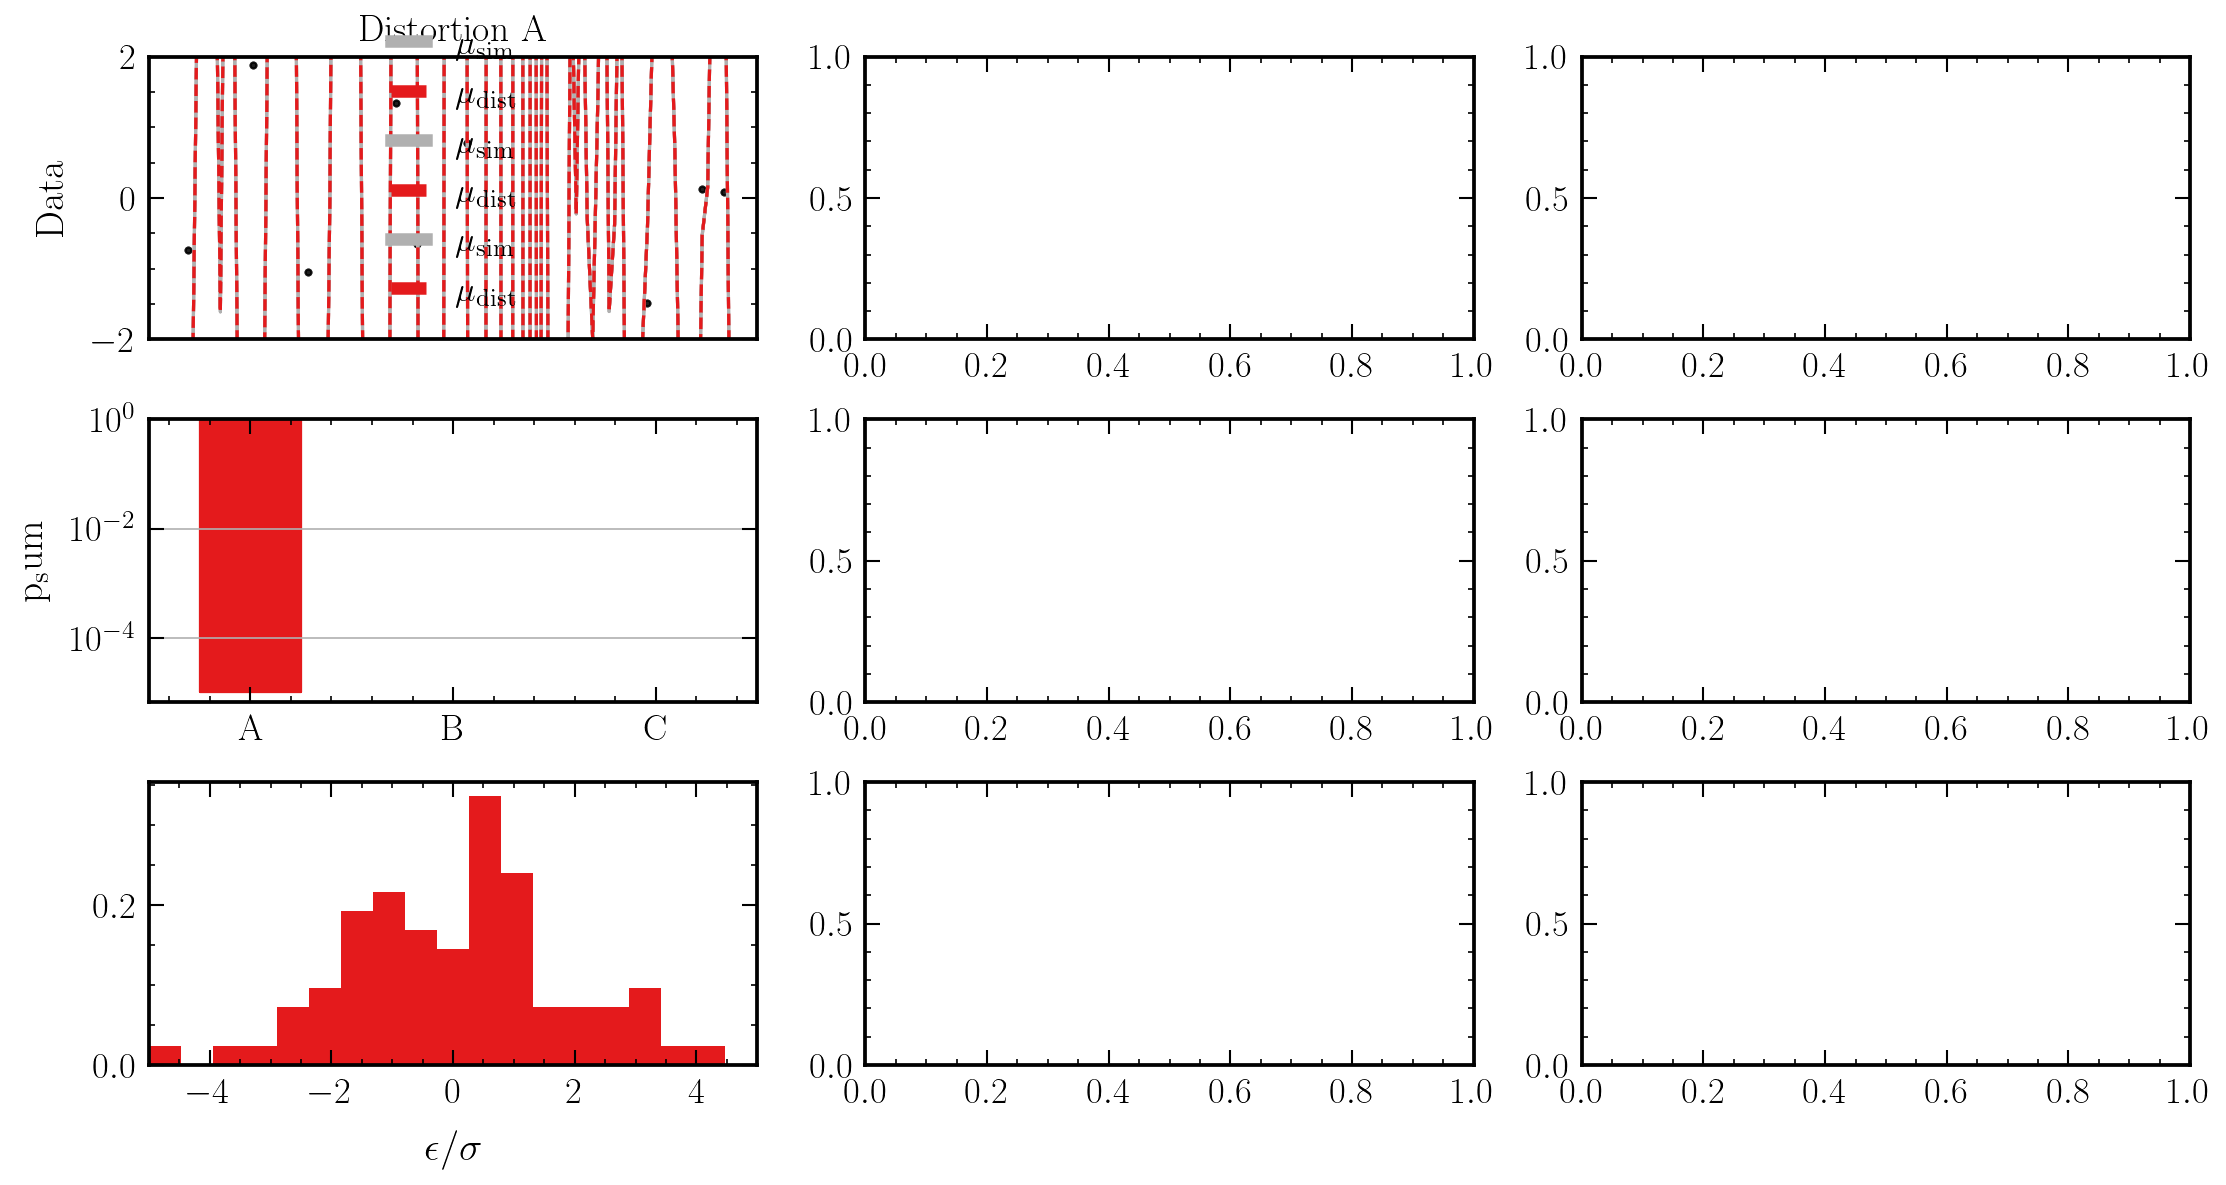

In [23]:
obs = simulator.sample(1)
# Choose clear distortion
# obs['x0'] = simulator.get_x_H0(1, obs['mu'])
# obs['ni'][obs['ni']==1] = 0
# obs['ni'][0,50] = 1
# obs['epsilon'] = obs['ni'].unsqueeze(1) * torch.tensor([4, 3, 2]).unsqueeze(0).unsqueeze(2)
# obs['cni'] = simulator.get_correlation(obs['ni'],  obs['epsilon'])
# obs['xi'] = simulator.get_x_Hi(obs['cni'], obs['x0'].unsqueeze(1))
    
fig, axs = plt.subplots(3, 3, figsize=(15, 8), dpi=150)
c = ['C0', 'C1', 'C2']
labels = ["A", "B", "C"]
for _ in range(3):
    
    i = 0
    target = obs['xi'][:, i].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    snr2_nn = network.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]
    variance_nn =  network.logvariance.exp().detach().cpu().numpy()                     #[len(correlation_scales), Nbins]
    ts_sum_nn = snr2_nn.sum(axis=-1)-ts_sum_H0_mean[0]
    p_sum_nn = np.stack([
        t_to_pvalue_empirical(ts_sum_nn[c], ts_sum_H0[:, c]) for c in range(len(simulator.correlation_scales))
    ], axis=0)        #[len(correlation_scales)]

    # Plotting
    axs[0, i].plot(grid, obs['mu'][0], color='#b0b0b0', label="$\mu_{\mathrm{sim}}$")
    axs[0, i].scatter(grid, obs['xi'][0, i], color='k', alpha=0.5, s=8)
    # axs[0, i].errorbar(grid, obs['xi'][0, i], yerr=1, fmt='none', ecolor='k', alpha=0.5)
    axs[0, i].plot(grid, obs['mu'][0]+dist[0, i], color=c[i], ls='--', label="$\mu_{\mathrm{dist}}$")
    axs[0, i].fill_between(grid, obs['mu'][0], obs['mu'][0]+dist[0, i], color=c[i], alpha=0.5)
    axs[0, i].set_title(f"Distortion {labels[i]}")
    axs[0, i].set_ylim(-2, 2)
    axs[0, i].set_xticks([])
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*1.5), 1)
    axs[1, i].set_xticks([0, 1, 2])
    axs[1, i].set_xticklabels(labels)
    axs[1, i].set_xlim(-0.5, 3 - 0.5)
    axs[1, i].grid(True, axis='y')
    for x, value_nn in zip([0, 1, 2], p_sum_nn):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        axs[1, i].fill_between([left, right], 1, value_nn, facecolor=c[x], edgecolor=c[x])
    
    bins = np.linspace(-5, 5, int(Nbins/5))
    for _ in range(3):
        x = 0
        axs[2, i].hist(epsilon_nn[x]/np.sqrt(variance_nn[x]), bins=bins, density=True, color=c[x], alpha=0.5)
        # axs[2, i].hist(epsilon_nn[x], bins=bins, density=True, color=c[x], alpha=0.5)
        # axs[2, i].hist(epsilon_analytical[x], bins=bins, density=True, histtype='step', color='k', alpha=0.4)
    axs[2, i].set_xlim(-5, 5)
    
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p_sum}$")
axs[2, 0].set_xlabel("$\epsilon / \sigma$")

for ax in axs[:, 0]:
    ax.legend(loc='best')

plt.tight_layout();

---

### Global deviations test

Trial correct for the fact that we looked Nbins times + aggregated tests. What’s the overall significance given I’ve looked so many times? Each of the trials is one test.


In [24]:
ts_bin_H0.shape, ts_sum_H0.shape

((98304, 1, 102), (98304, 1))

Compute p-values for the individual tests (Nbins)

In [25]:
N_mc, num_resolutions, num_bins = ts_bin_H0.shape
ts_bin_flat = ts_bin_H0.reshape(N_mc, num_resolutions * num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_resolutions * num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_resolutions * num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_resolutions * num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_resolutions, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_resolutions, num_bins)

# # Initialize an array to hold the p-values
# p_values = np.zeros_like(ts_centered)

# # For each test statistic (flattened index), compute the p-values
# for idx in range(ts_centered.shape[1]):
#     ts0_ref = ts_centered[:, idx]  # Shape: [N_mc]
#     ts_obs = ts0_ref  # Observed values are the same as ts0_ref in this context

#     # Sort the reference distribution
#     sorted_ts0_ref = np.sort(ts0_ref)

#     # Compute ranks using searchsorted
#     ranks = np.searchsorted(sorted_ts0_ref, ts_obs, side='right')

#     # Adjust counts to exclude the observed value itself
#     counts = N_mc - 1  # Exclude ts_obs from counts

#     # Since ts_obs is included in ts0_ref, subtract 1 from ranks and counts
#     p_values[:, idx] = 1 - (ranks - 1) / counts

# # Reshape p_values back to [N_mc, num_resolutions, num_bins]
# pv_bin_H0 = p_values.reshape(N_mc, num_resolutions, num_bins)    
    
pv_bin_H0.shape

(98304, 1, 102)

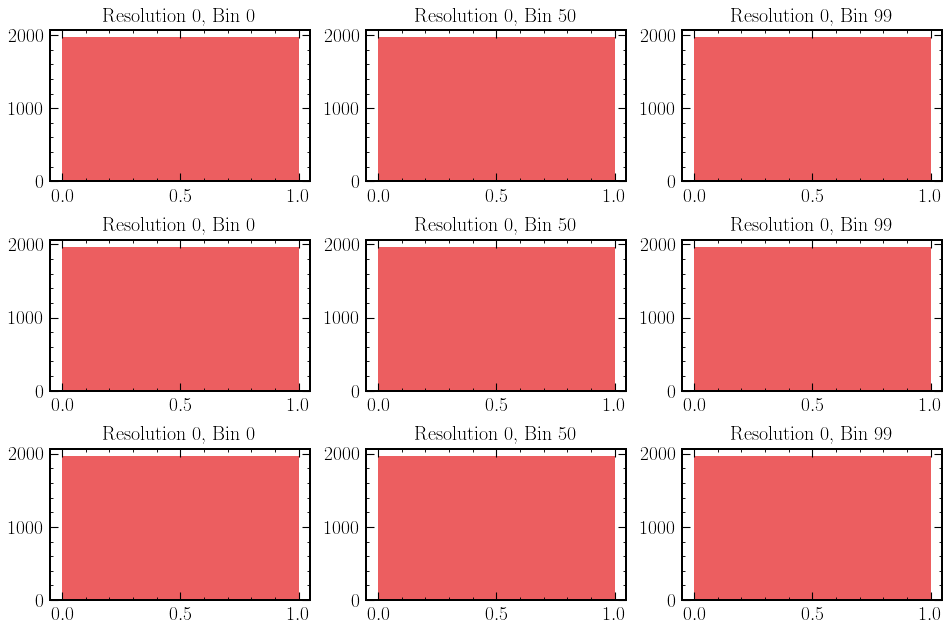

In [26]:
# p-values are uniformly distributed

# selected_resolutions = [0, 1, 2]       # Resolutions to plot
selected_resolutions = [0, 0, 0]       # Resolutions to plot

selected_bins = [0, 50, 99]            # Bins to plot

fig, axs = plt.subplots(len(selected_resolutions), len(selected_bins), figsize=(12, 8))
for i, res in enumerate(selected_resolutions):
    for j, bin_idx in enumerate(selected_bins):
        pv_data = pv_bin_H0[:, res, bin_idx]
        axs[i, j].hist(pv_data, bins=50, alpha=0.7)
        axs[i, j].set_title(f'Resolution {res}, Bin {bin_idx}')

plt.tight_layout()
plt.show()

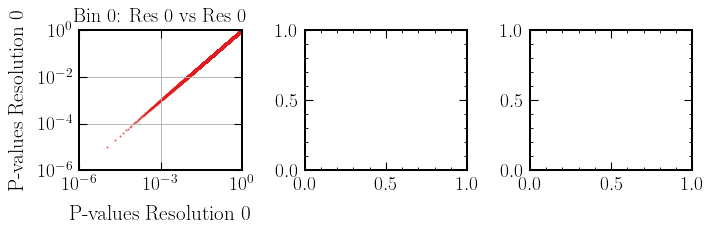

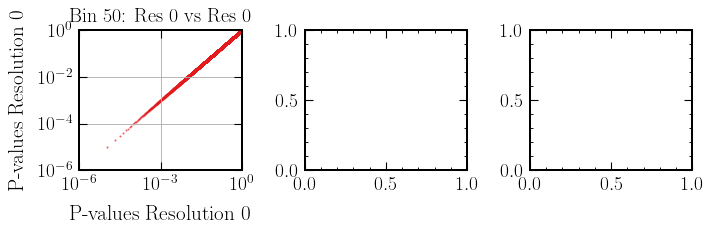

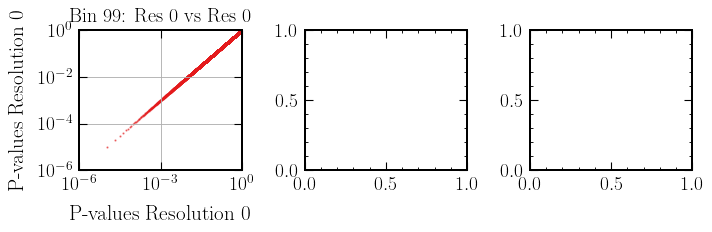

In [27]:
# p-values between different tests are correlated

bins_to_analyze = [0, 50, 99] 

for bin_idx in bins_to_analyze:
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    # resolution_pairs = [(0, 1), (0, 2), (1, 2)]
    resolution_pairs = [(0, 0)]
    for i, (res1, res2) in enumerate(resolution_pairs):
        p_values_res1 = pv_bin_H0[:, res1, bin_idx]
        p_values_res2 = pv_bin_H0[:, res2, bin_idx]

        axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
        axs[i].set_xlabel(f'P-values Resolution {res1}')
        axs[i].set_ylabel(f'P-values Resolution {res2}')
        axs[i].set_title(f'Bin {bin_idx}: Res {res1} vs Res {res2}')
        axs[i].set_xlim(1e-6, 1)
        axs[i].set_ylim(1e-6, 1)
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


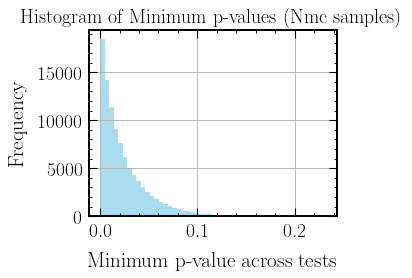

In [28]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0 = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_bin_H0, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Compute p-values for the total tests

In [29]:
N_mc, num_resolutions = ts_sum_H0.shape
means = ts_sum_H0.mean(axis=0)  # Shape: [num_resolutions]
ts_centered = ts_sum_H0 - means  # Shape: [N_mc, num_resolutions]
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_resolutions]
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
p_values = (ranks + 1) / N_mc
pv_sum_H0 = p_values.reshape(N_mc, num_resolutions) 
pv_sum_H0.shape

(98304, 1)

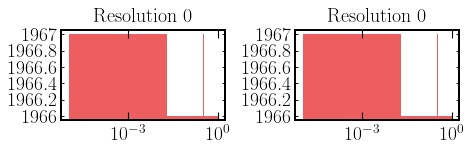

In [30]:
# selected_resolutions = [0, 1, 2]       # Resolutions to plot
selected_resolutions = [0, 0 ]       # Resolutions to plot


fig, axs = plt.subplots(1, len(selected_resolutions), figsize=(6, 2))

for i, res in enumerate(selected_resolutions):
    pv_data = pv_bin_H0[:, res, bin_idx]
    axs[i].hist(pv_data, bins=50, alpha=0.7)
    axs[i].set_title(f'Resolution {res}')
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

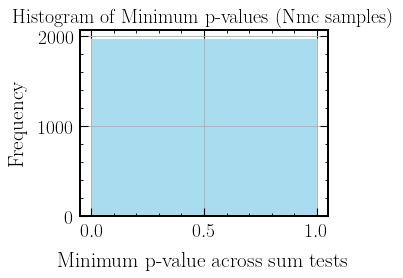

In [31]:
min_pv_sum_H0 = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_sum_H0, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across sum tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Consider all tests

(98304, 103)


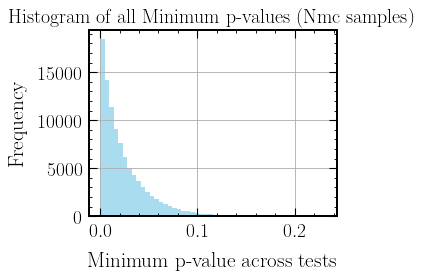

In [32]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([pv_bin_H0.reshape(Nmc, -1), pv_sum_H0], axis=1)  # Shape: [Nmc, num_resolutions * num_bins + num_resolutions]
print(pv_all_H0.shape)

min_pv_all_H0 = np.min(pv_all_H0, axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_all_H0, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of all Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


In [33]:
ts_bin_H0.shape, ts_sum_H0.shape

((98304, 1, 102), (98304, 1))

---

## Summary plot

In [34]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler

c = ["C0", "C1", "C2"]
mygold = (218/255, 165/255, 32/255, 0.1)  

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

In [35]:
def analyse_obs(obs, i_c):
    
    target = obs['xi'][:, i_c].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)

    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    variance_nn = network.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]
    snr2_nn = network.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]
    ts_sum_nn = snr2_nn.sum(axis=-1)-ts_sum_H0_mean[0]
    p_sum_nn = np.stack([
        t_to_pvalue_empirical(ts_sum_nn[c], ts_sum_H0[:, c]) for c in range(len(simulator.correlation_scales))
    ], axis=0)        #[len(correlation_scales)]

    # Compute p-values
    _p_nn = []
    for idx, ts_bin in enumerate(snr2_nn.T):
        ts_bin_i = ts_bin_H0[:, :, idx]          #[N_mc, len(correlation_scales)]
        m = ts_bin_i.mean(0)                     #[len(correlation_scales)]
        ts0_ref = ts_bin_i - m                   #[N_mc, len(correlation_scales)]
        ts_obs = (ts_bin - m)
        _p_nn.append(np.stack([
            t_to_pvalue_empirical(ts_obs[c], ts0_ref[:, c]) for c in range(len(simulator.correlation_scales))
        ], axis=0))        #[len(correlation_scales)]
    p_nn = np.array(_p_nn)                   #[Nbins, len(correlation_scales)]


    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn.reshape(-1).min()
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [num_resolutions * Nbins]
        p_sum_nn  # Shape: [num_resolutions]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0 <= obs_min_pv_bin)
    p_glob_sum = np.mean(min_pv_sum_H0 <= obs_min_pv_sum)
    p_glob_all = np.mean(min_pv_all_H0 <= obs_min_pv_all)

    return epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all

def plot_analysis(obs, epsilon_nn, variance_nn, p_nn, p_sum_nn, p_glob_all, i_c, ax_dist=True):
    
    dist1 = obs['xi'] - obs['x0']

    # Figure
    c = ["C0", "C1", "C2"]
    fig = plt.figure(figsize=(10, 8), dpi=250)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.3)

    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0, i_c]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = times
    ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    ax1.scatter(grid, xi, color='k', marker='x', s=6)
    # plt.errorbar(grid, xi, yerr=1, fmt='none', ecolor='k', alpha=0.5)
    # plt.fill_between(grid, obs['mu'][0]-1, obs['mu'][0]+1,  color='#b0b0b0', alpha=0.1)
    # plt.fill_between(grid, obs['mu'][0]-2, obs['mu'][0]+2,  color='#b0b0b0', alpha=0.2)
    # plt.fill_between(grid, obs['mu'][0]-3, obs['mu'][0]+3,  color='#b0b0b0', alpha=0.3)
    ax1.plot(grid, obs['mu'][0]+dist1[0, i], color=c[i], label="$\mu_{\mathrm{dist B}}$")
    ax1.fill_between(grid, obs['mu'][0], obs['mu'][0]+dist1[0, i_c], color=c[i_c], alpha=0.5)
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    # ax1.plot([], [], c='k', label="$x_\mathrm{obs}$")
    # ax1.legend(loc='best', handlelength=1)
    # ax1.set_xticklabels([])
    # ax1.set_ylim(-6.5, 6.5)
    # ax1.set_xlabel("$i$", labelpad=1.5)
    ax1.legend(fontsize=12, bbox_to_anchor=[0.6,0.65,0,0], labelspacing=0.1)
    ax1.set_xticks([])
    ax1.set_title("Data")

    if ax_dist:
        ax_dist = fig.add_subplot(gs[0, 1])
        mask = np.where(dist1[0,-1]!=0)
        fakegrid = torch.linspace(0, len(mask[0]), len(mask[0]))
        ax_dist.plot(fakegrid, dist1[0,0][mask]/dist1[0,0][mask].max()+2)
        ax_dist.plot(fakegrid, dist1[0,1][mask]/dist1[0,1][mask].max())
        ax_dist.plot(fakegrid, dist1[0,2][mask]/dist1[0,2][mask].max()-2)
        ax_dist.text(fakegrid.max() + 3, 2, 'A', verticalalignment='center')
        ax_dist.text(fakegrid.max() + 3, 0, 'B', verticalalignment='center')
        ax_dist.text(fakegrid.max() + 3, -2, 'C', verticalalignment='center')
        ax_dist.axis('off')
        ax_dist.set_ylim(-5,5)
        ax_dist.set_xlim(-len(mask[0]),2*len(mask[0]))
        ax_dist.set_title("Distortions")

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    # ax2.set_facecolor(apricot)
    ax2.semilogy(grid, p_nn)
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='lower right',  fontsize=15)
    ax2.set_ylim(1/(N_mc*5), 1)
    # ax2.set_xlabel("$i$", labelpad=1.5)
    ax2.set_title("Anomaly detection")
    ax2.grid(True, axis='y')
    ax2.set_xticks([])


    ax3 = fig.add_subplot(gs[2, 0])
    # ax3.set_facecolor(dandelion)
    ax3.plot(grid, epsilon_nn.T)
    ax3.set_ylabel(r"$\epsilon_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    ax3.axhline(0, color='#b0b0b0', ls='--', lw=1)
    # ax3.set_xlabel("$i$", labelpad=1.5)
    ax3.set_title("Residual analysis")
    # ax3.set_ylim(-6.5, 6.5)
    ax3.set_xticks([])


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    # ax4.set_facecolor(salmon)
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1, 2])
    ax4.set_xticklabels(["A", "B","C"])
    ax4.set_xlim(-0.5, 3 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.grid(True, axis='y', which='both')
    for x, value_nn in zip([0, 1, 2], p_sum_nn):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        ax4.fill_between([left, right], 1, value_nn, facecolor=c[x], edgecolor=c[x])
    ax4.set_title("Model validation")
    ax4.tick_params(axis="x",direction="in", pad=-25)
    ax4.minorticks_off()


    # Hist
    ax6 = fig.add_subplot(gs[2, 1])
    # ax6.set_facecolor(coral)
    bins = np.linspace(-5, 5, int(Nbins/5))
    for x in range(len(correlation_scales)):
        ax6.hist(epsilon_nn[x] / np.sqrt(variance_nn[x]), bins=bins, density=True, histtype='stepfilled', lw=1.5, color=c[x], alpha=0.2)
        ax6.hist(epsilon_nn[x] / np.sqrt(variance_nn[x]), bins=bins, density=True, histtype='step', lw=1.5, ec=c[x])
    ax6.set_xlim(-5, 5)
    ax6.set_xlabel("$\epsilon_\mathrm{obs} / \sigma$")
    ax6.set_title("Residual variance analysis")

    # Add on gs[0, 1] text reporting the three global p-values
    # ax_text = fig.add_subplot(gs[0, 1])
    # ax_text.set_facecolor(mygold)
    # textstr = '\n'.join((
    #     r'$p_{\mathrm{glob}}^{\mathrm{bin}}=%.2e$' % (p_glob_bin, ),
    #     r'$p_{\mathrm{glob}}^{\mathrm{sum}}=%.2e$' % (p_glob_sum, ),
    #     r'$p_{\mathrm{glob}}^{\mathrm{all}}=%.2e$' % (p_glob_all, )))
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    # ax_text.text(0.5, 0.5, textstr, transform=ax_text.transAxes, fontsize=14,
    #              verticalalignment='center', horizontalalignment='center',
    #              bbox=dict(
    #                 facecolor=mygold,
    #                 edgecolor='none'  # Remove the border if not needed
    #             )
    #             )

    # ax_text.text(0.5, 0.8, "Global p-value", transform=ax_text.transAxes, fontsize=18,
    #              verticalalignment='center', horizontalalignment='center')
    # ax_text.axis('off')
    # ax_text.set_title("Global p-value")
    ax3.text(0.6, -0.4, textstr, transform=ax3.transAxes, fontsize=14,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax3.text(0.2, -0.4, "Global p-value", transform=ax3.transAxes, fontsize=18,
                verticalalignment='center', horizontalalignment='center')

    # plt.savefig("plot1.pdf", transparent=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


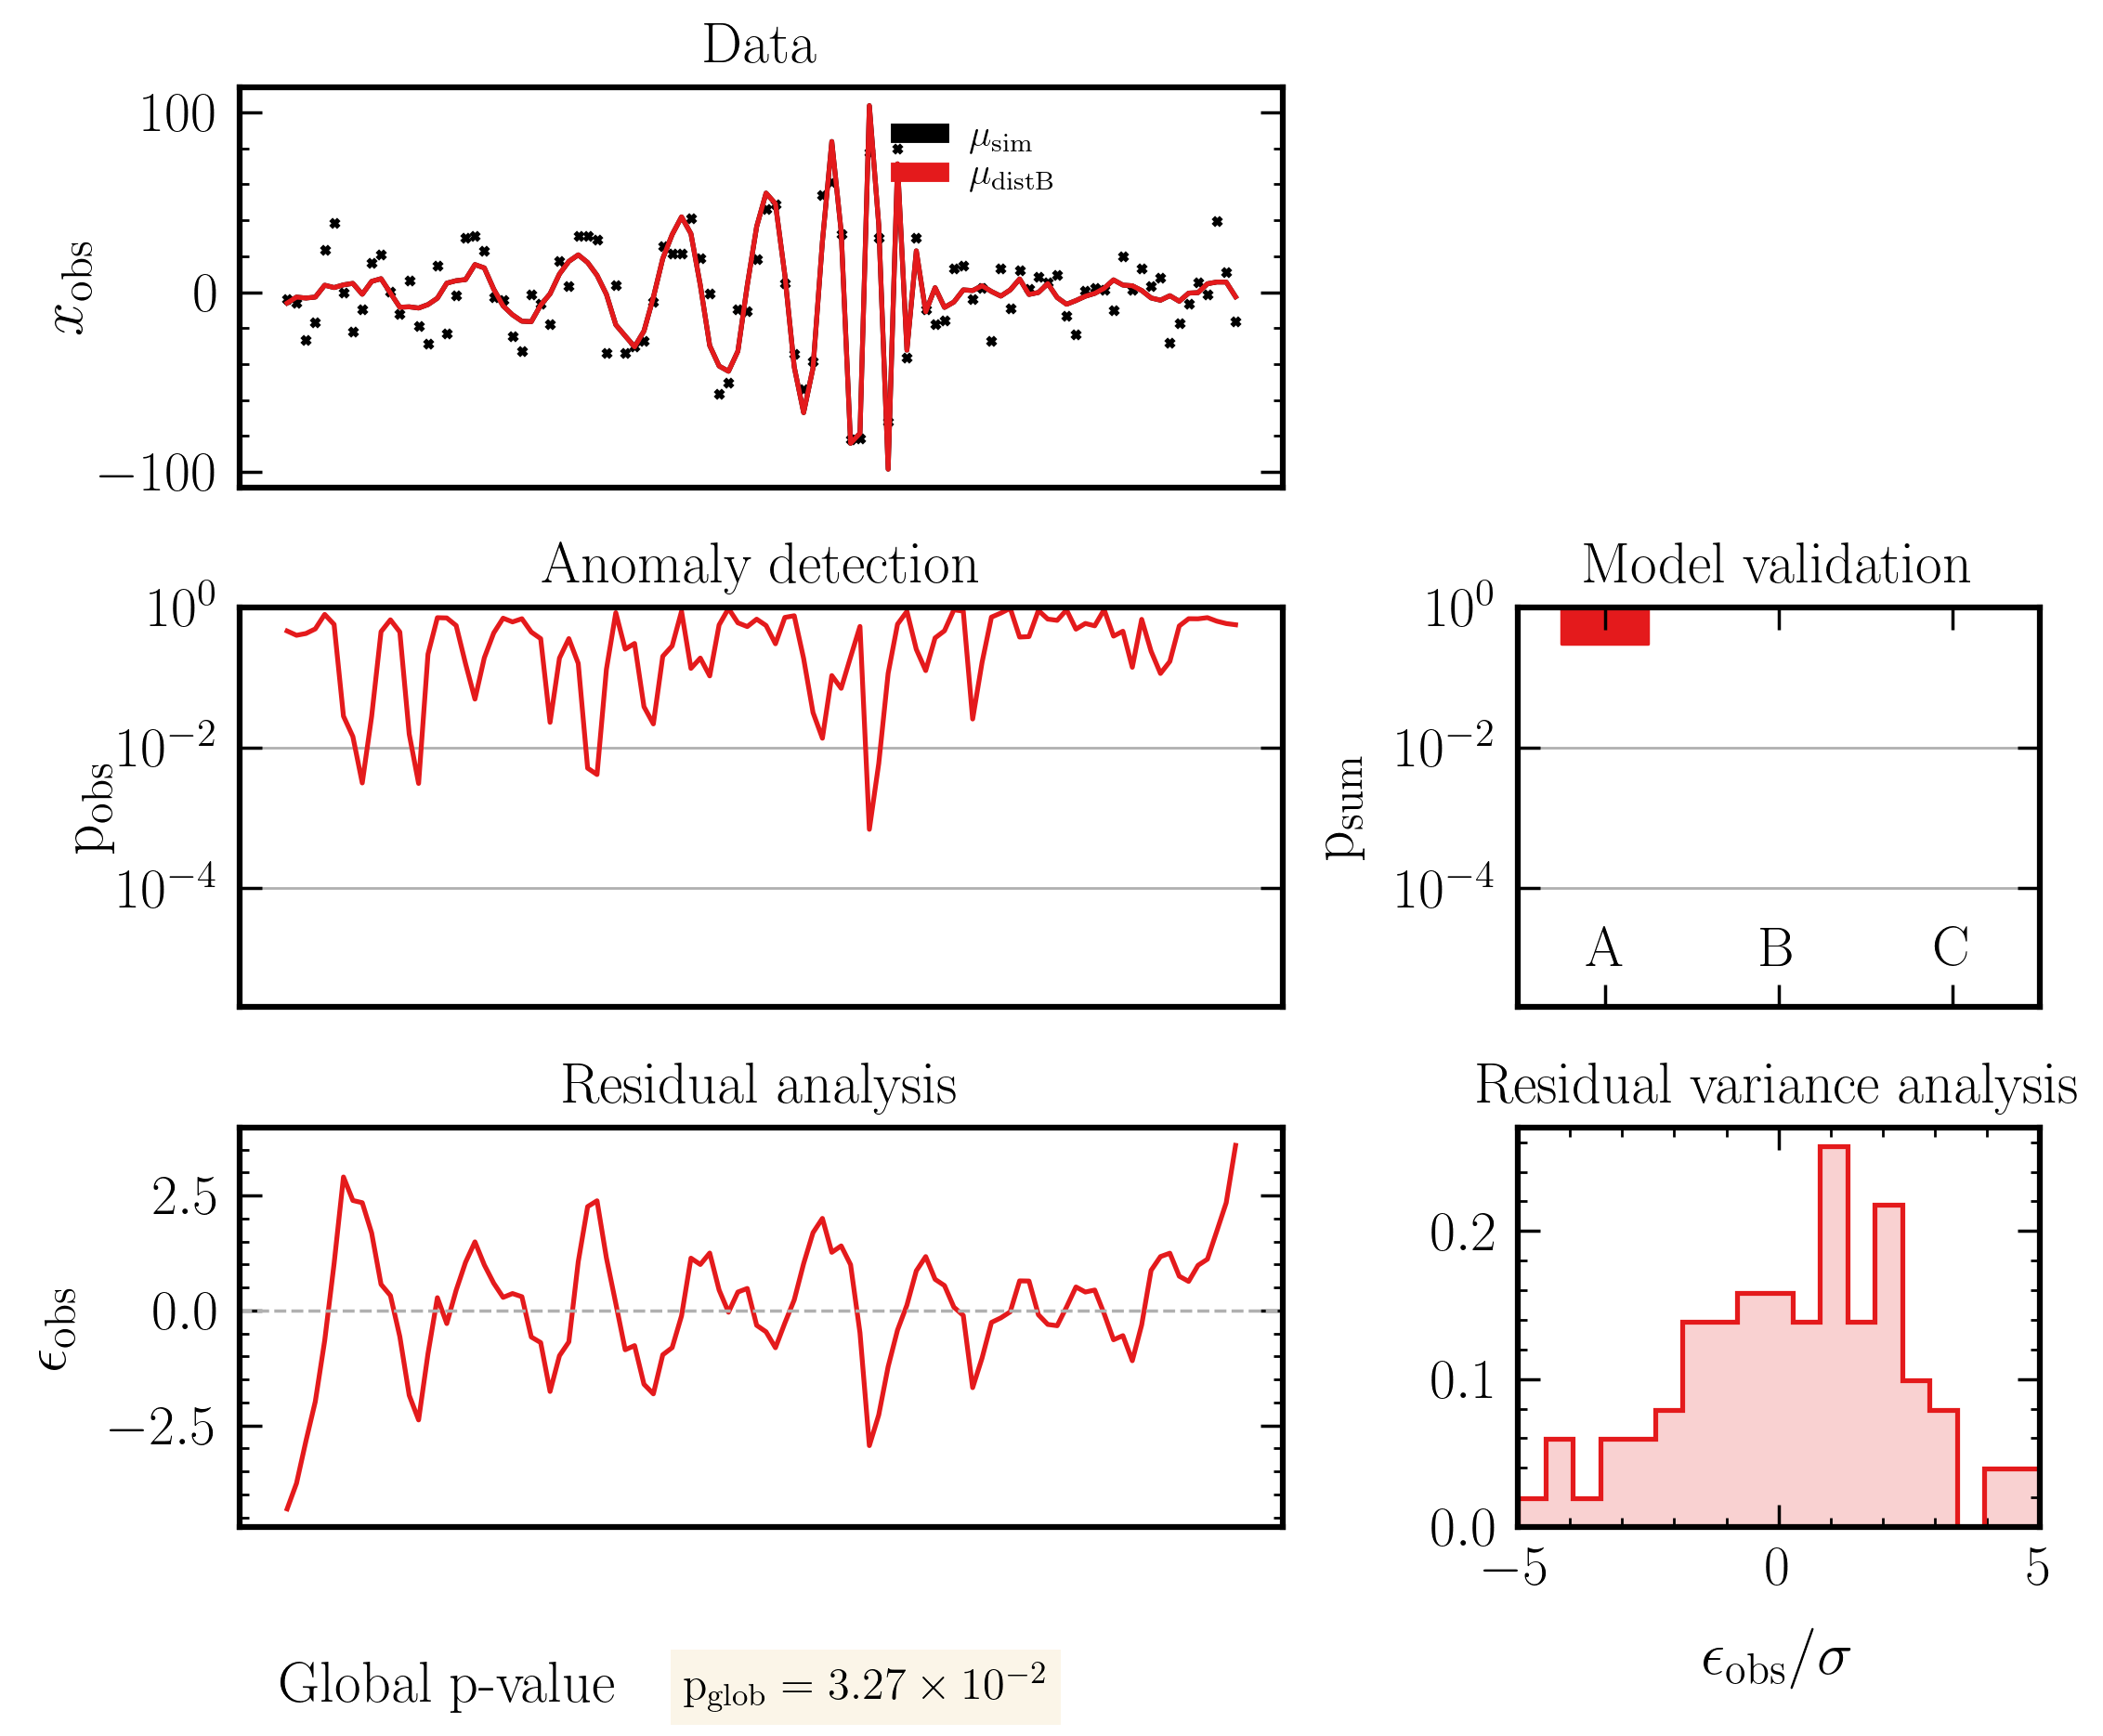

In [36]:
# NO SIGNAL
obs = simulator.sample(1)
obs['xi'] = obs['x0'].unsqueeze(1).repeat(1, len(simulator.correlation_scales), 1)
i = 0

epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all = analyse_obs(obs, i)
plot_analysis(obs, epsilon_nn, variance_nn, p_nn, p_sum_nn, p_glob_all, i, ax_dist=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


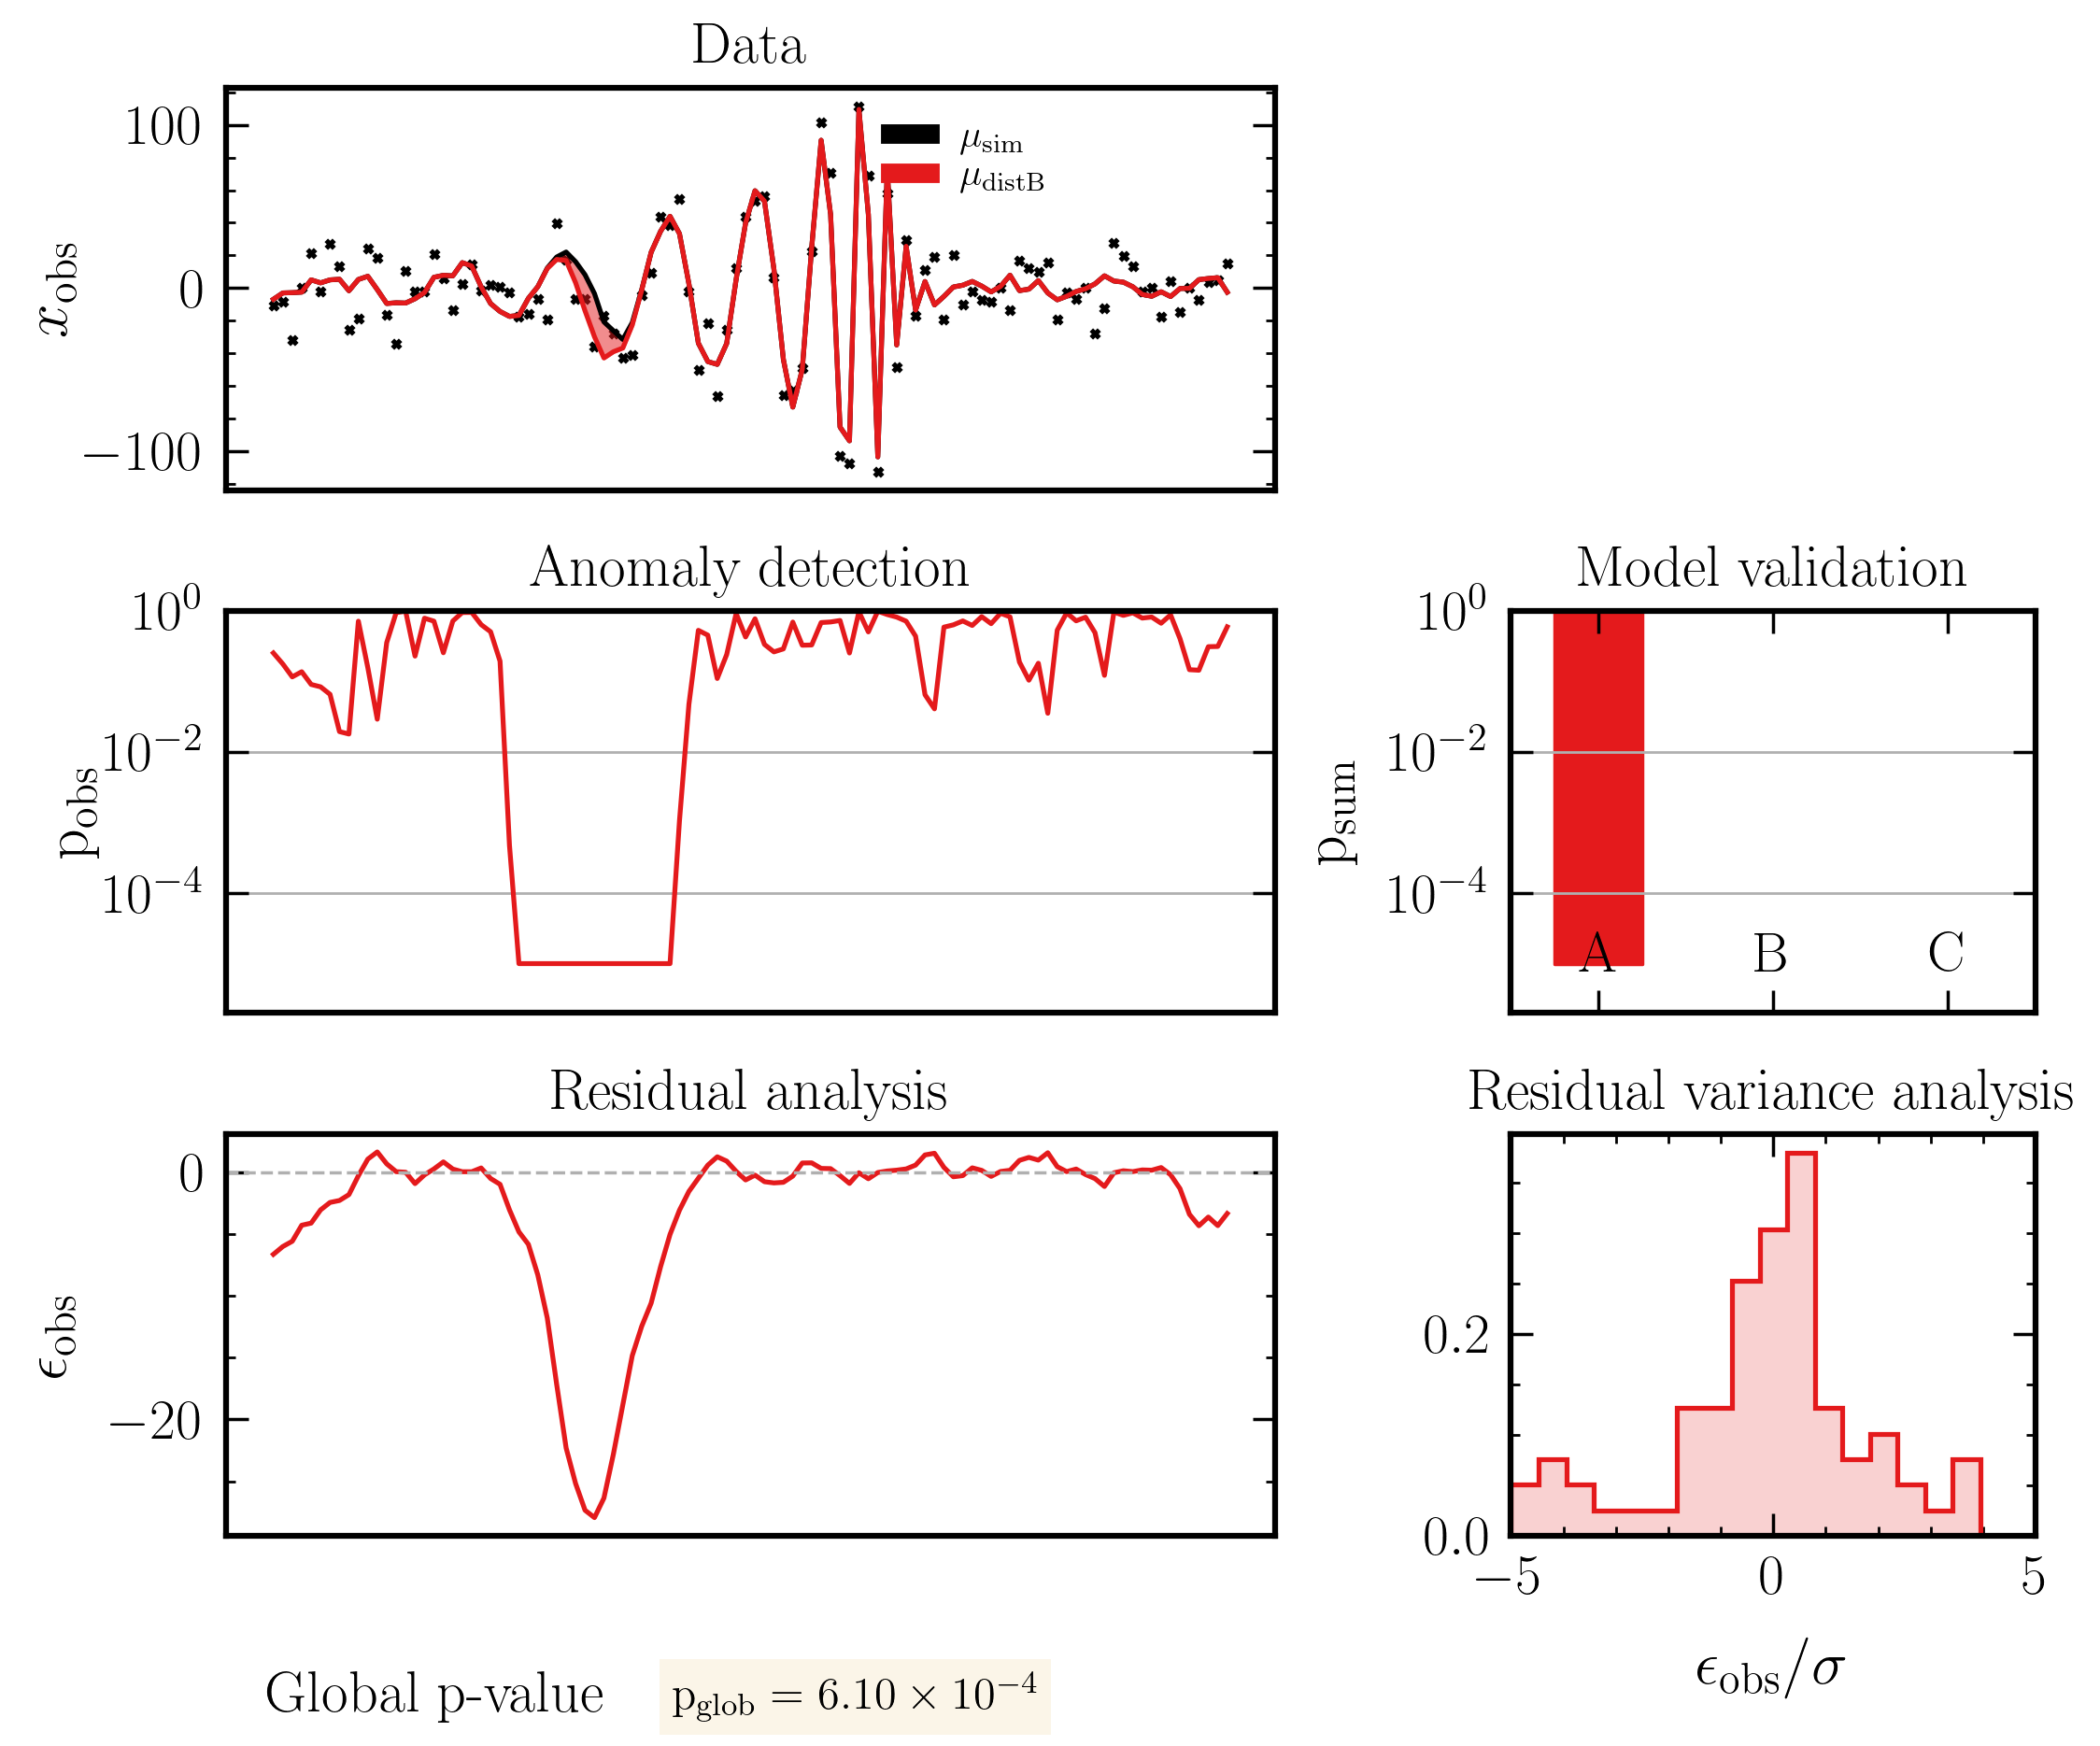

In [37]:
obs = simulator.sample(1) 
i = 0

epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all = analyse_obs(obs, i)
plot_analysis(obs, epsilon_nn, variance_nn, p_nn, p_sum_nn, p_glob_all, i,ax_dist=False)

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from GW150814_posterior_samples.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


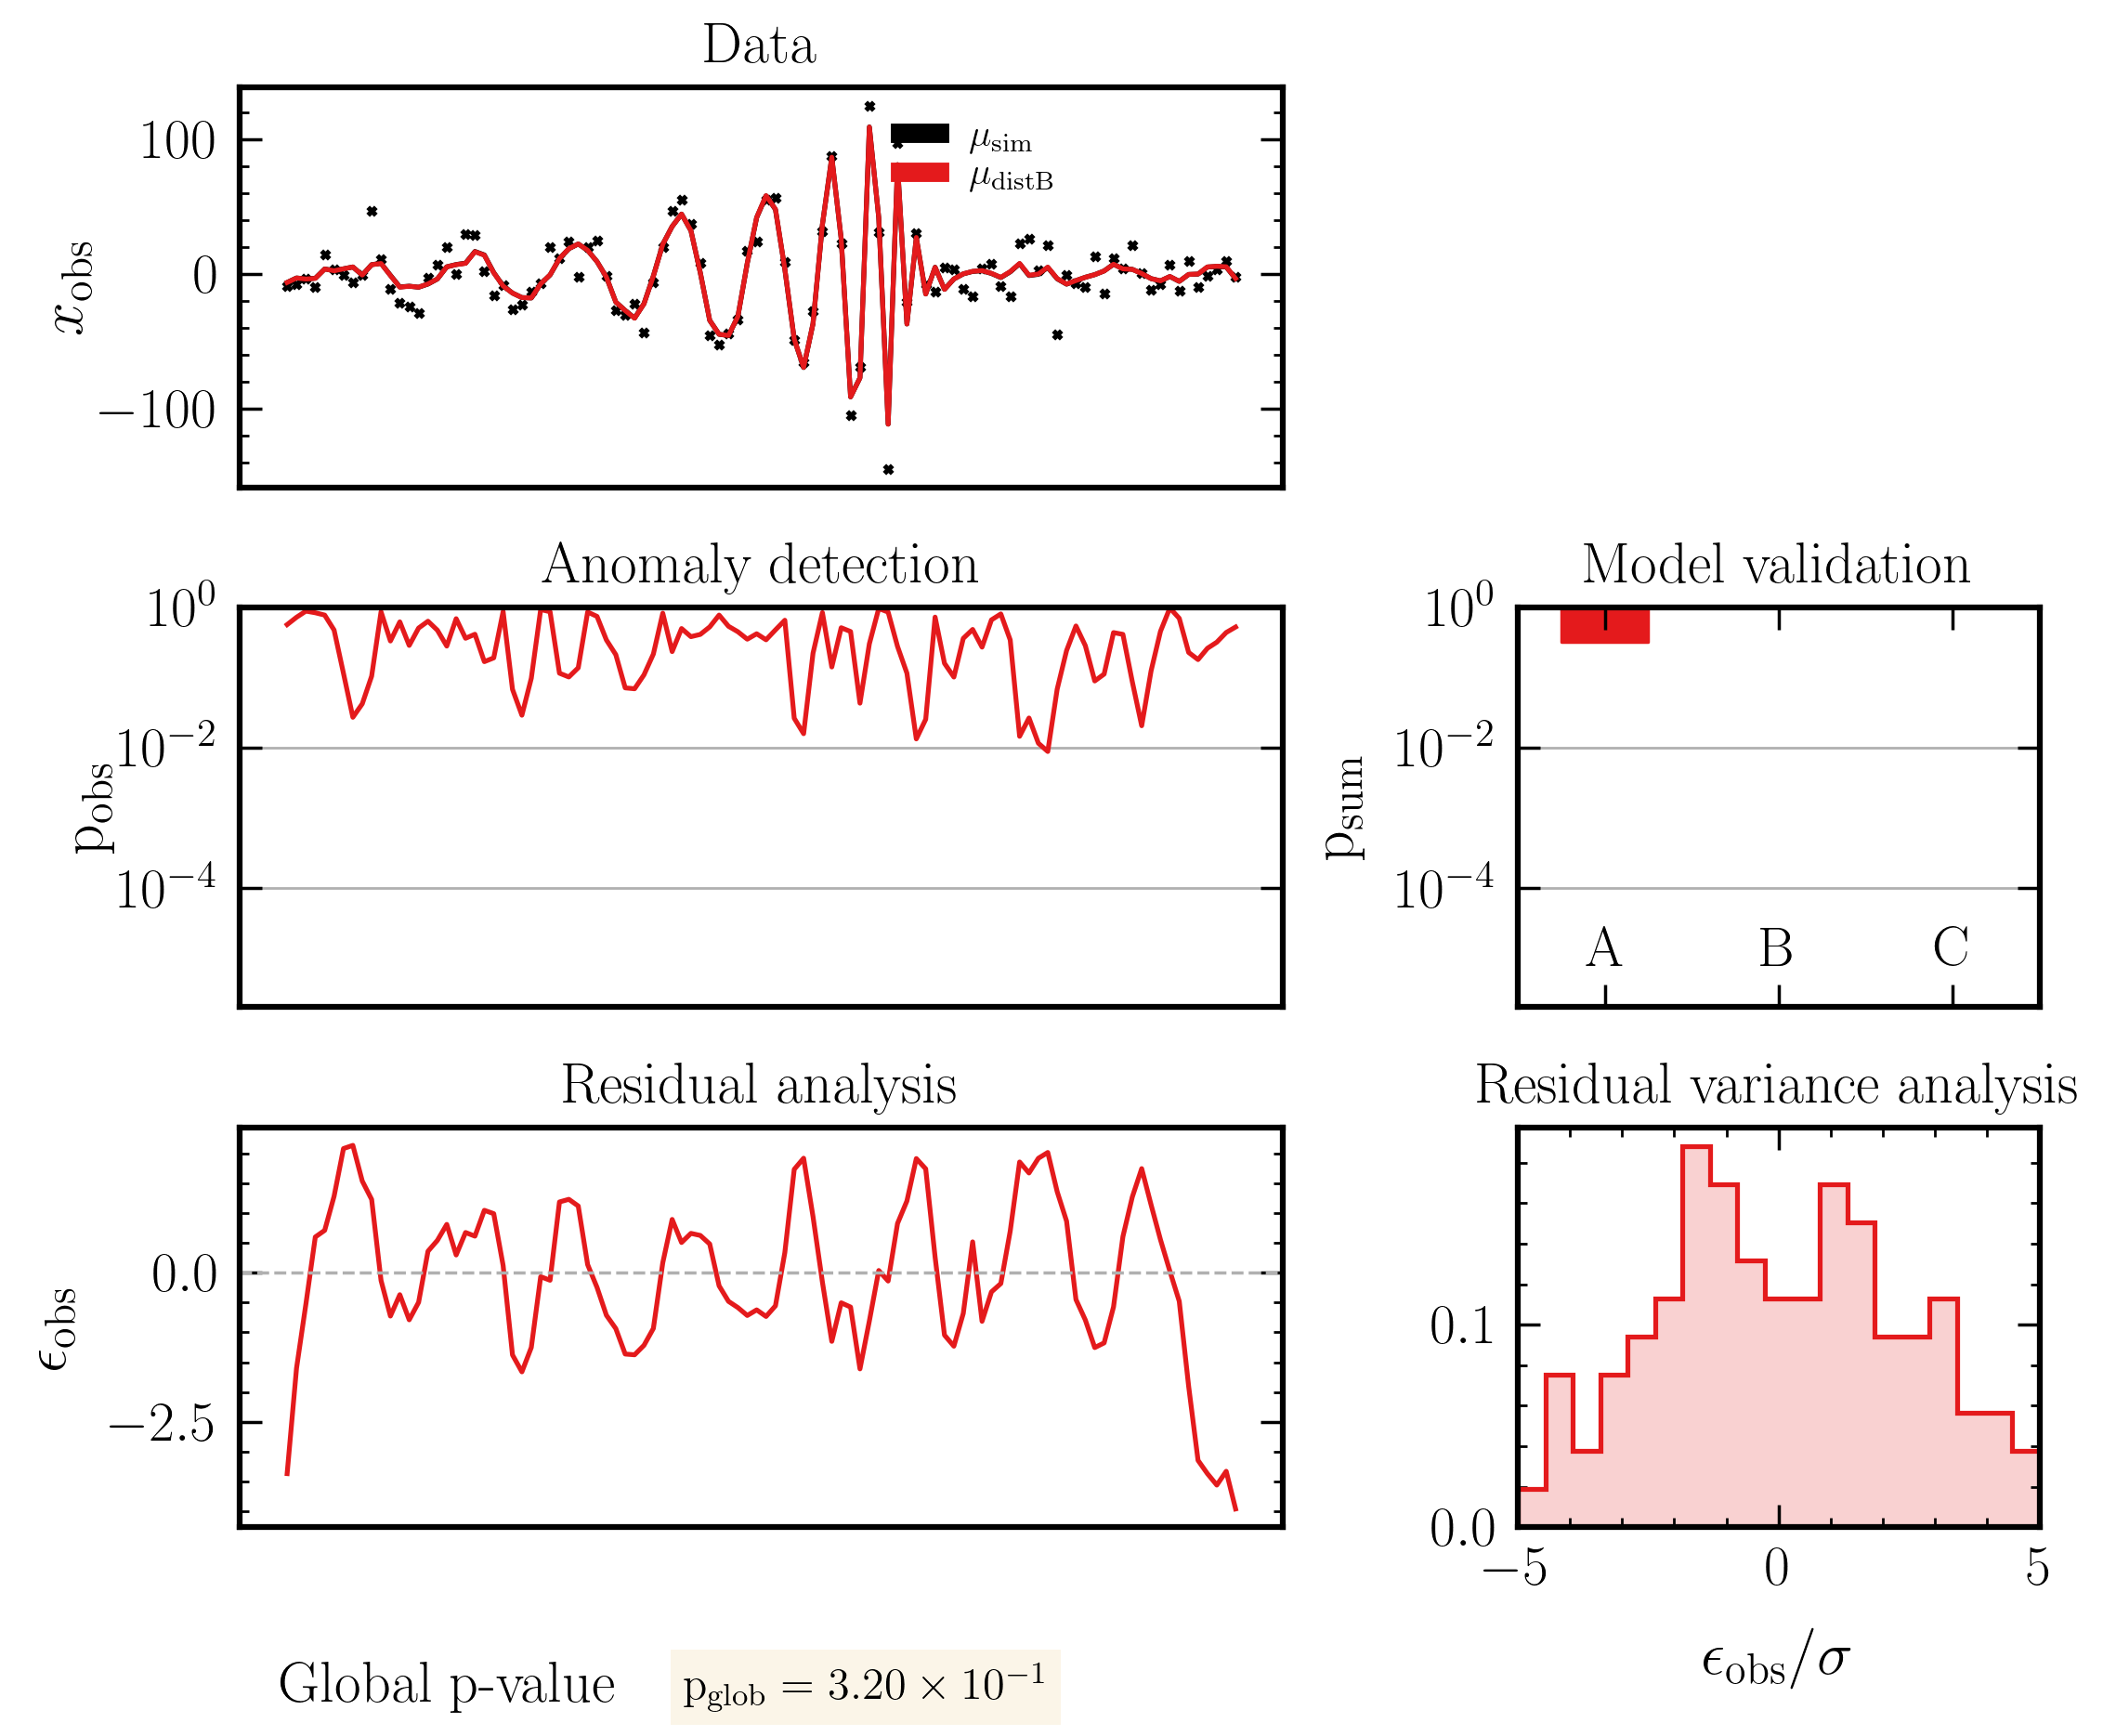

In [38]:
simulator1 = GW150814_Additive(
    gw150814_samples=gw150814_samples, 
    fraction=0.9, 
    sample_fraction=False, 
    bounds=0.1, 
    correlation_scales = correlation_scales,
    dtype=torch.float32, 
)
obs = simulator1.sample(1)
i = 0

epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all = analyse_obs(obs, i)
plot_analysis(obs, epsilon_nn, variance_nn, p_nn, p_sum_nn, p_glob_all, i,ax_dist=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1105485/3628754192.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


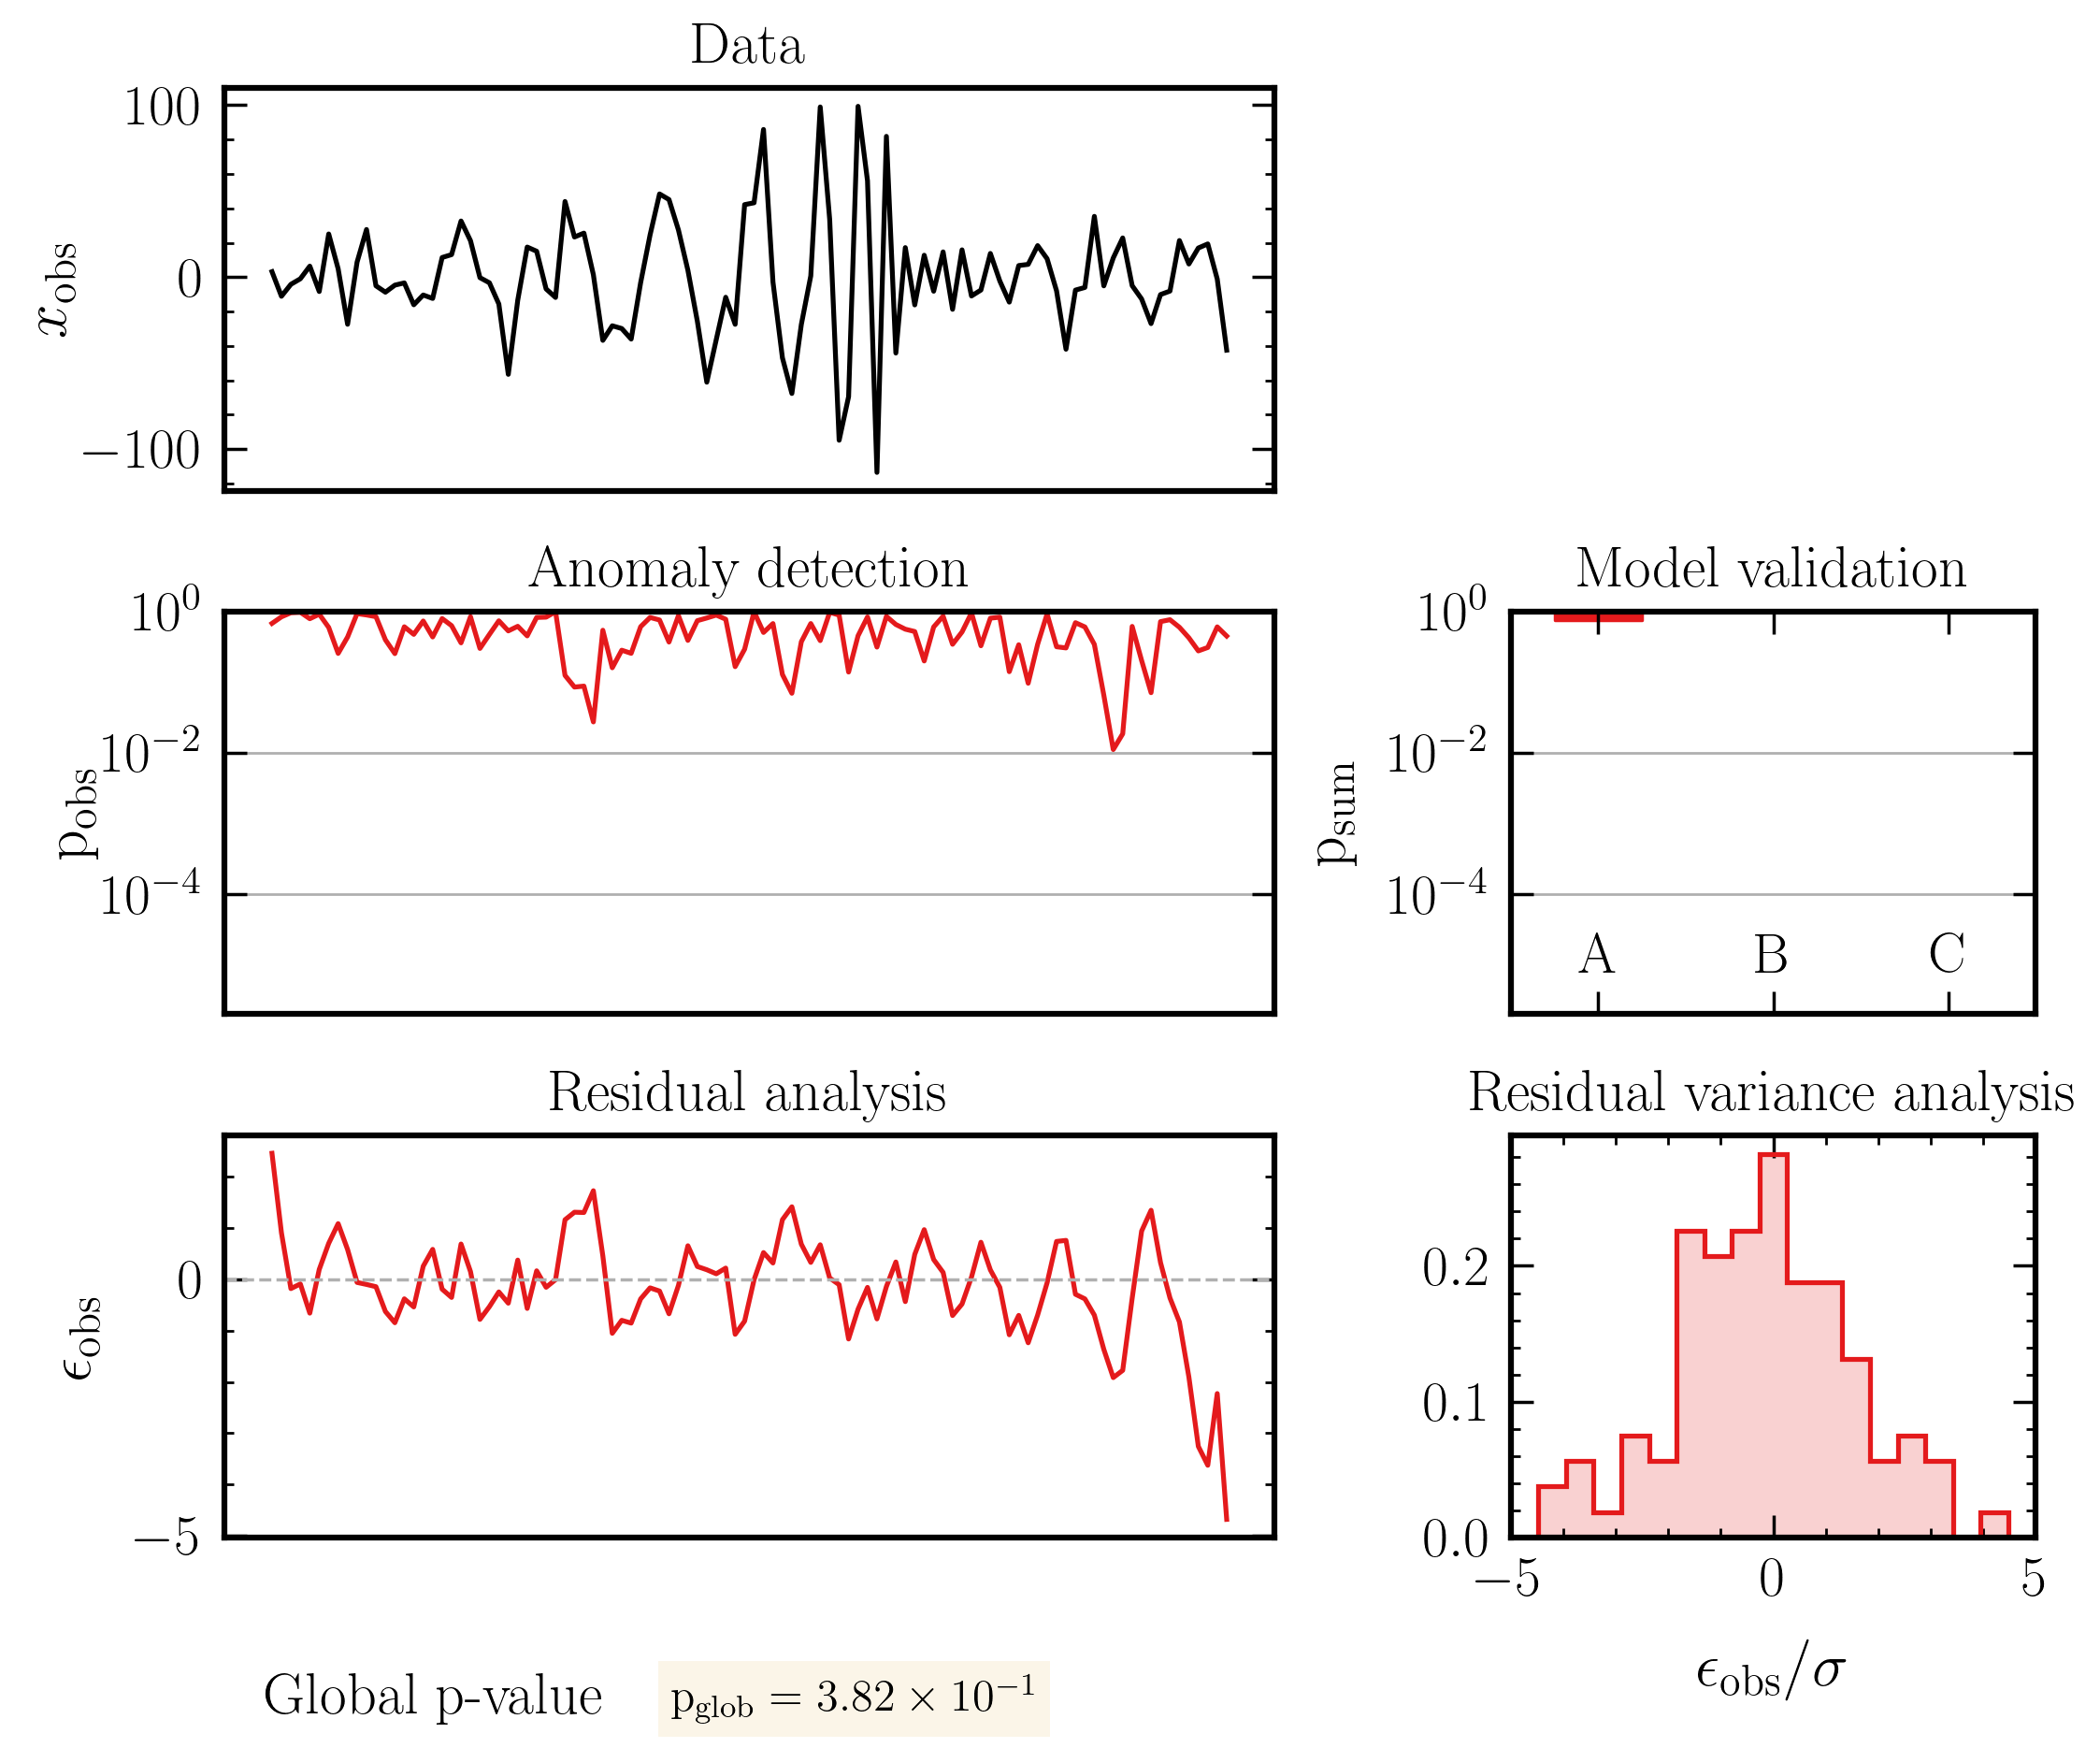

In [40]:
# REAL DATA
gw150814 = simulator._jax_to_torch(simulator._process(simulator.filter_gwosc_data()))
obs = {'xi': gw150814.to(torch.float32).unsqueeze(0).unsqueeze(0).repeat(1,3, 1)}

epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all = analyse_obs(obs, i)


#### PLOT

i = 0
# Figure
c = ["C0", "C1", "C2"]
fig = plt.figure(figsize=(10, 8), dpi=250)
gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.3)

# First row: ax1 spans both columns
ax1 = fig.add_subplot(gs[0, 0])
xi = obs['xi'][0]
ax1.plot(grid, xi[i], color='k')
ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
# ax1.plot([], [], c='k', label="$x_\mathrm{obs}$")
# ax1.legend(loc='best', handlelength=1)
# ax1.set_xticklabels([])
# ax1.set_ylim(-6.5, 6.5)
# ax1.set_xlabel("$i$", labelpad=1.5)
ax1.legend(fontsize=12, bbox_to_anchor=[0.6,0.65,0,0], labelspacing=0.1)
ax1.set_xticks([])
ax1.set_title("Data")

# ax_dist = fig.add_subplot(gs[0, 1])
# mask = np.where(dist1[0,-1]!=0)
# fakegrid = torch.linspace(0, len(mask[0]), len(mask[0]))
# ax_dist.plot(fakegrid, dist1[0,0][mask]/dist1[0,0][mask].max()+2)
# ax_dist.plot(fakegrid, dist1[0,1][mask]/dist1[0,1][mask].max())
# ax_dist.plot(fakegrid, dist1[0,2][mask]/dist1[0,2][mask].max()-2)
# ax_dist.text(fakegrid.max() + 3, 2, 'A', verticalalignment='center')
# ax_dist.text(fakegrid.max() + 3, 0, 'B', verticalalignment='center')
# ax_dist.text(fakegrid.max() + 3, -2, 'C', verticalalignment='center')
# ax_dist.axis('off')
# ax_dist.set_ylim(-5,5)
# ax_dist.set_xlim(-len(mask[0]),2*len(mask[0]))
# ax_dist.set_title("Distortions")

# Second column: ax2 and ax3 in the first column
ax2 = fig.add_subplot(gs[1, 0])
# ax2.set_facecolor(apricot)
ax2.semilogy(grid, p_nn)
ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
ax2.legend(loc='lower right',  fontsize=15)
ax2.set_ylim(1/(N_mc*5), 1)
# ax2.set_xlabel("$i$", labelpad=1.5)
ax2.set_title("Anomaly detection")
ax2.grid(True, axis='y')
ax2.set_xticks([])


ax3 = fig.add_subplot(gs[2, 0])
# ax3.set_facecolor(dandelion)
ax3.plot(grid, epsilon_nn.T)
ax3.set_ylabel(r"$\epsilon_\mathrm{obs}$")
ax3.legend(loc='best',  fontsize=13)
ax3.axhline(0, color='#b0b0b0', ls='--', lw=1)
# ax3.set_xlabel("$i$", labelpad=1.5)
ax3.set_title("Residual analysis")
ax3.set_xticks([])


# Second column: ax4 and ax6 in the second column

# Bars
ax4 = fig.add_subplot(gs[1, 1])
# ax4.set_facecolor(salmon)
ax4.set_yscale('log')
ax4.set_ylim(1/(N_mc*5), 1)
ax4.set_xticks([0, 1, 2])
ax4.set_xticklabels(["A", "B","C"])
ax4.set_xlim(-0.5, 3 - 0.5)
ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
ax4.grid(True, axis='y', which='both')
for x, value_nn in zip([0, 1, 2], p_sum_nn):
    left = x - 0.5 / 2
    right = x + 0.5 / 2
    ax4.fill_between([left, right], 1, value_nn, facecolor=c[x], edgecolor=c[x])
ax4.set_title("Model validation")
ax4.tick_params(axis="x",direction="in", pad=-25)
ax4.minorticks_off()


# Hist
ax6 = fig.add_subplot(gs[2, 1])
# ax6.set_facecolor(coral)
bins = np.linspace(-5, 5, int(Nbins/5))
for x in range(len(correlation_scales)):
    ax6.hist(epsilon_nn[x] / np.sqrt(variance_nn[x]), bins=bins, density=True, histtype='stepfilled', lw=1.5, color=c[x], alpha=0.2)
    ax6.hist(epsilon_nn[x] / np.sqrt(variance_nn[x]), bins=bins, density=True, histtype='step', lw=1.5, ec=c[x])
ax6.set_xlim(-5, 5)
ax6.set_xlabel("$\epsilon_\mathrm{obs} / \sigma$")
ax6.set_title("Residual variance analysis")

# Add on gs[0, 1] text reporting the three global p-values
mantissa, exp = ('%.2e' % p_glob_all).split('e')
exp = int(exp)
textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
ax3.text(0.6, -0.4, textstr, transform=ax3.transAxes, fontsize=14,
             verticalalignment='center', horizontalalignment='center',
             bbox=dict(
                facecolor=mygold,
                edgecolor='none'  # Remove the border if not needed
            )
        )
ax3.text(0.2, -0.4, "Global p-value", transform=ax3.transAxes, fontsize=18,
             verticalalignment='center', horizontalalignment='center')

plt.tight_layout();